In [1]:
import os
import copy
import re
import logging
import datetime
import csv
import itertools
import warnings
import multiprocessing

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from tqdm import tqdm
from tqdm.contrib import tzip

import cobra
from cobra.io import load_model, read_sbml_model
from cobra.flux_analysis import flux_variability_analysis, find_essential_reactions

from optlang import cplex_interface

logging.getLogger("cobra.io.sbml").setLevel(logging.ERROR)
logging.getLogger("cobra").setLevel(logging.ERROR)
%matplotlib inline

num_cores = multiprocessing.cpu_count()
processes_num = max(num_cores - 2, 1)

# Bacterial species and growth media

In [2]:
species = [
    "Agrobacterium tumefaciens",
    "Alcaligenes faecalis",
    "Delftia acidovorans",
    "Pandoraea vervacti",
    "Pantoea agglomerans",
    "Pseudomonas asiatica",
    "Pseudomonas delhiensis",
    "Sphingomonas paucimobilis"
]

models = [
    "Agrobacterium_tumefaciens_gapfill.xml",
    "Alcaligenes_faecalis_gapfill.xml",
    "Delftia_acidovorans_gapfill.xml",
    "Pandoraea_vervacti_gapfill.xml",
    "Pantoea_agglomerans_gapfill.xml",
    "Pseudomonas_asiatica_gapfill.xml",
    "Pseudomonas_delhiensis_gapfill.xml",
    "Sphingomonas_paucimobilis_gapfill.xml"
]

species_abb = [
    "AgT", "AlF", "DeA", "PaV", "PaA", "PsA", "PsD", "SpP"
]

sp_model_df = pd.DataFrame({
    "species": species,
    "models": models,
    "species_abb": species_abb
})

sp_model_df

,species,models,species_abb
0,Agrobacterium tumefaciens,Agrobacterium_tumefaciens_gapfill.xml,AgT
1,Alcaligenes faecalis,Alcaligenes_faecalis_gapfill.xml,AlF
2,Delftia acidovorans,Delftia_acidovorans_gapfill.xml,DeA
3,Pandoraea vervacti,Pandoraea_vervacti_gapfill.xml,PaV
4,Pantoea agglomerans,Pantoea_agglomerans_gapfill.xml,PaA
5,Pseudomonas asiatica,Pseudomonas_asiatica_gapfill.xml,PsA
6,Pseudomonas delhiensis,Pseudomonas_delhiensis_gapfill.xml,PsD
7,Sphingomonas paucimobilis,Sphingomonas_paucimobilis_gapfill.xml,SpP


In [3]:
# Check objective function
for i in models:
    print(i)

    model = read_sbml_model(
        "GEM_with_gapfilling_M9media/" + str(i)
    )

    print(model.objective)

Agrobacterium_tumefaciens_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Alcaligenes_faecalis_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Delftia_acidovorans_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Pandoraea_vervacti_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Pantoea_agglomerans_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Pseudomonas_asiatica_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Pseudomonas_delhiensis_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Sphingomonas_paucimobilis_gapfill.xml
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae


# Retrieve all reactions containing carobon metabolites in all gems

In [4]:
mtbrxn_all_models = []

for i in tqdm(np.arange(len(models))):
    model = read_sbml_model("GEM_with_gapfilling_M9media/" + models[i])
    mtbrxn_list = []  # all metabolites in gems

    for reaction in model.reactions:
        for metabolite, stoichiometry in reaction.metabolites.items():
            mtbrxn_item = pd.DataFrame(
                [[reaction.id, metabolite.id, metabolite.name, metabolite.formula]],
                columns=["reaction", "metabolite", "name", "formula"]
            )
            mtbrxn_list.append(mtbrxn_item)

    mtbrxn_df = pd.concat(mtbrxn_list, axis=0)
    mtbrxn_df = mtbrxn_df.reset_index(drop=True)
    mtbrxn_all_models.append(mtbrxn_df)

mtbrxn_all_df = pd.concat(mtbrxn_all_models)
mtbrxn_all_df = mtbrxn_all_df.drop_duplicates(subset=["reaction", "metabolite"])
mtbrxn_all_df = mtbrxn_all_df.reset_index(drop=True)

non_carbons = ["Cl", "Co", "Cu", "Ca", "Cd"]

mtbrxn_all_df["carbon_atom"] = "Absence"
mtbrxn_all_df.loc[mtbrxn_all_df["formula"].str.contains(r'^C'), ["carbon_atom"]] = "Presence"
mtbrxn_all_df.loc[mtbrxn_all_df["formula"].isin(non_carbons), ["carbon_atom"]] = "Absence"  # all metabolites in gems

mtbrxn_all_df = mtbrxn_all_df[mtbrxn_all_df["carbon_atom"] == "Presence"]
mtbrxn_all_df = mtbrxn_all_df.reset_index(drop=True)

mtbrxn_all_df

100%|█████████████████████████████████████████████| 8/8 [00:46<00:00,  5.81s/it]


,reaction,metabolite,name,formula,carbon_atom
0,EX_14glucan_e,14glucan_e,"1,4-alpha-D-glucan",C36H62O31,Presence
1,EX_23camp_e,23camp_e,"2',3'-Cyclic AMP",C10H11N5O6P,Presence
2,EX_23ccmp_e,23ccmp_e,"2',3'-Cyclic CMP",C9H11N3O7P,Presence
3,EX_23cgmp_e,23cgmp_e,"2',3'-Cyclic GMP",C10H11N5O7P,Presence
4,EX_23cump_e,23cump_e,"2',3'-Cyclic UMP",C9H10N2O8P,Presence
...,...,...,...,...,...
12102,PLPS_1,glu__L_c,L-Glutamate,C5H8NO4,Presence
12103,PLPS_1,pydx5p_c,Pyridoxal 5'-phosphate,C8H8NO6P,Presence
12104,PYROX_1,pyr_c,Pyruvate,C3H3O3,Presence
12105,PYROX_1,actp_c,Acetyl phosphate,C2H3O5P,Presence


# Retrieve all metabolites in all gems

In [5]:
mtb_all_models = []

for i in tqdm(np.arange(len(models))):
    model = read_sbml_model("GEM_with_gapfilling_M9media/" + models[i])
    mtb_list = []  # all metabolites in gems    

    for metabolite in model.metabolites:  # all metabolites in gems
        mtb_item = pd.DataFrame(
            [[metabolite.id, metabolite.name, metabolite.formula]],
            columns=["metabolite", "name", "formula"]
        )
        mtb_list.append(mtb_item)

    mtb_df = pd.concat(mtb_list, axis=0)
    mtb_df = mtb_df.reset_index(drop=True)
    mtb_df["species"] = species[i]
    mtb_all_models.append(mtb_df)

mtb_df = pd.concat(mtb_all_models)
mtb_df = mtb_df.drop_duplicates(subset=["metabolite"])
mtb_df = mtb_df.reset_index(drop=True)

non_carbons = ["Cl", "Co", "Cu", "Ca", "Cd"]
mtb_df["carbon_atom"] = "Absence"
mtb_df.loc[mtb_df["formula"].str.contains(r'^C'), ["carbon_atom"]] = "Presence"
mtb_df.loc[mtb_df["formula"].isin(non_carbons), ["carbon_atom"]] = "Absence"

mtb_df = mtb_df.drop(columns="species")
mtb_df

100%|█████████████████████████████████████████████| 8/8 [00:29<00:00,  3.67s/it]


,metabolite,name,formula,carbon_atom
0,10fthf_c,10-Formyltetrahydrofolate,C20H21N7O7,Presence
1,12dgr120_c,"1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)",C27H52O5,Presence
2,12dgr140_c,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,Presence
3,12dgr140_p,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,Presence
4,12dgr141_c,"1,2-Diacyl-sn-glycerol (ditetradec-7-enoyl, n-...",C31H56O5,Presence
...,...,...,...,...
2481,lpro_c,Lipoylprotein S2X,C8H14NOS2,Presence
2482,lysglugly_c,Lysine-glutamine-glycine tripeptide,C13H26N4O7,Presence
2483,lysglugly_e,Lysine-glutamine-glycine tripeptide,C13H26N4O7,Presence
2484,pprdn_c,Piperideine,C5H9N,Presence


In [6]:
# M9 media
M9_singles = pd.read_csv("M9_singles.tsv", sep="\t")
carbons = M9_singles[M9_singles["type"] == "Carbon"]["name"]
M9_singles

,reaction,metabolite,global_id,flux,keggId,formulae,descriptive_name,type,name,mw,...,Citrate,Glucose,Ribose,Glycerol,Cellobiose,Serine,Isoleucine,Sorbitol,Uridine,Raffinose
0,EX_succ_m,succ_m,EX_succ_e,10,C00042,C4H4O4,Succinate,Carbon,Succinate,116.07000,...,0,0,0,0,0,0,0,0,0,0
1,EX_ala__L_m,ala__L_m,EX_ala__L_e,10,C00041,C3H7NO2,L-Alanine,Carbon,Alanine,89.09000,...,0,0,0,0,0,0,0,0,0,0
2,EX_gln__L_m,gln__L_m,EX_gln__L_e,10,C00064,C5H10N2O3,L-Glutamine,Carbon,Glutamine,146.14000,...,0,0,0,0,0,0,0,0,0,0
3,EX_pro__L_m,pro__L_m,EX_pro__L_e,10,C00148,C5H9NO2,L-Proline,Carbon,Proline,115.13000,...,0,0,0,0,0,0,0,0,0,0
4,EX_ac_m,ac_m,EX_ac_e,10,C00033,C2H3O2,Acetate,Carbon,Acetate,59.04000,...,0,0,0,0,0,0,0,0,0,0
5,EX_mnl_m,mnl_m,EX_mnl_e,10,C00392,C6H14O6,D-Mannitol,Carbon,Mannitol,182.17000,...,0,0,0,0,0,0,0,0,0,0
6,EX_cit_m,cit_m,EX_cit_e,10,C00158,C6H5O7,Citrate,Carbon,Citrate,189.12400,...,10,0,0,0,0,0,0,0,0,0
7,EX_glc__D_m,glc__D_m,EX_glc__D_e,10,C00031,C6H12O6,D-Glucose,Carbon,Glucose,180.15600,...,0,10,0,0,0,0,0,0,0,0
8,EX_rib__D_m,rib__D_m,EX_rib__D_e,10,C00121,C5H10O5,D-Ribose,Carbon,Ribose,150.13000,...,0,0,10,0,0,0,0,0,0,0
9,EX_glyc_m,glyc_m,EX_glyc_e,10,C00116,C3H8O3,Glycerol,Carbon,Glycerol,92.09382,...,0,0,0,10,0,0,0,0,0,0


In [7]:
# carbon sources
carbon_rank_df = pd.DataFrame({
    "carbon": carbons,
    "theta_rank": np.arange(len(carbons))
})

carbon_rank_df

,carbon,theta_rank
0,Succinate,0
1,Alanine,1
2,Glutamine,2
3,Proline,3
4,Acetate,4
5,Mannitol,5
6,Citrate,6
7,Glucose,7
8,Ribose,8
9,Glycerol,9


In [8]:
# set carbon source flux to be equal mass
glc_flux_list = [0.25, 0.5, 1, 4, 2, 8]

glc_mw = M9_singles[M9_singles["name"] == "Glucose"]["mw"]
k = 0
glc_flux = glc_flux_list[k]
glc_grm = glc_mw * glc_flux

M9_media = copy.deepcopy(M9_singles)
M9_media[carbons] = M9_media[carbons].astype(float)

for l in np.arange(len(carbons)):
    my_mw = M9_media["mw"][l]
    my_grm = glc_grm / my_mw
    my_grm = my_grm.to_numpy()
    M9_media.loc[[l], carbons[l]] = my_grm

M9_media

,reaction,metabolite,global_id,flux,keggId,formulae,descriptive_name,type,name,mw,...,Citrate,Glucose,Ribose,Glycerol,Cellobiose,Serine,Isoleucine,Sorbitol,Uridine,Raffinose
0,EX_succ_m,succ_m,EX_succ_e,10,C00042,C4H4O4,Succinate,Carbon,Succinate,116.07000,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,EX_ala__L_m,ala__L_m,EX_ala__L_e,10,C00041,C3H7NO2,L-Alanine,Carbon,Alanine,89.09000,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,EX_gln__L_m,gln__L_m,EX_gln__L_e,10,C00064,C5H10N2O3,L-Glutamine,Carbon,Glutamine,146.14000,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,EX_pro__L_m,pro__L_m,EX_pro__L_e,10,C00148,C5H9NO2,L-Proline,Carbon,Proline,115.13000,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,EX_ac_m,ac_m,EX_ac_e,10,C00033,C2H3O2,Acetate,Carbon,Acetate,59.04000,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,EX_mnl_m,mnl_m,EX_mnl_e,10,C00392,C6H14O6,D-Mannitol,Carbon,Mannitol,182.17000,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,EX_cit_m,cit_m,EX_cit_e,10,C00158,C6H5O7,Citrate,Carbon,Citrate,189.12400,...,0.238145,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,EX_glc__D_m,glc__D_m,EX_glc__D_e,10,C00031,C6H12O6,D-Glucose,Carbon,Glucose,180.15600,...,0.000000,0.25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,EX_rib__D_m,rib__D_m,EX_rib__D_e,10,C00121,C5H10O5,D-Ribose,Carbon,Ribose,150.13000,...,0.000000,0.00,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,EX_glyc_m,glyc_m,EX_glyc_e,10,C00116,C3H8O3,Glycerol,Carbon,Glycerol,92.09382,...,0.000000,0.00,0.0,0.489056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Load genome-scale metabolic models and FBA

In [9]:
# load gems and examin FBA under different growth media 
flx_all_models = []
gr_all_models = []
nzfmtb_all_models = []

for m in tqdm(np.arange(len(glc_flux_list))):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    glc_flux = glc_flux_list[m]
    glc_grm = glc_mw * glc_flux

    M9_media = copy.deepcopy(M9_singles)
    M9_media[carbons] = M9_media[carbons].astype(float)

    for l in np.arange(len(carbons)):
        my_mw = M9_media["mw"][l]
        my_grm = glc_grm / my_mw
        my_grm = my_grm.to_numpy()
        M9_media.loc[[l], carbons[l]] = my_grm


    for i in np.arange(len(models)):
        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + "  " + str(species[i]))

        model = read_sbml_model("GEM_with_gapfilling_M9media/" + models[i])

        df_list = []     # flux distribution
        gr_list = []     # growth: biomass production rate in mmol/gDW/h
        nzfmtb_list = [] # nonzero flux metabolites

        for j in np.arange(len(carbons)):
            print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + "  " + str(species[i]) + " under " + str(carbons[j]))

            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                medium = model.medium  # load pre-defined medium

            for k in medium.keys(): 
                medium[k] = 0  # set uptake rate for all compounds to 0

            for ex, val in zip(M9_media["global_id"], M9_media[carbons[j]]):
                if model.reactions.has_id(ex):
                    medium[ex] = val

            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                model.medium = medium  # define medium

            model.solver = cplex_interface.Model()
            solution = model.optimize()  # FBA
            value = solution.objective_value

            es_item = find_essential_reactions(model, value * 0.99, processes=processes_num)  # set of essential reactions
            es_df = pd.DataFrame(es_item, columns=["reaction_item"], dtype="string")
            es_df["reaction"] = es_df["reaction_item"].str.extract(r'(^.*: )')
            es_df["reaction"] = es_df["reaction"].str.replace(": ", "")

            my_df = pd.DataFrame({carbons[j]: solution.fluxes})  # flux distribution
            if j == 0:
                my_df["reaction"] = my_df.index
            df_list.append(my_df)

            my_gr = pd.DataFrame({carbons[j]: solution.objective_value}, index=["0"])  # growth
            gr_list.append(my_gr)

            nonzero_metabolites = []  # nonzero flux metabolites under a given medium
            for reaction in model.reactions:
                if solution.fluxes[reaction.id] != 0:
                    for metabolite, stoichiometry in reaction.metabolites.items():
                        mtbrxn_item = pd.DataFrame([[metabolite.id, reaction.id]], columns=["metabolite", "reaction"])
                        nonzero_metabolites.append(mtbrxn_item)

            if len(nonzero_metabolites) > 0:
                my_mtb = pd.concat(nonzero_metabolites)
                my_mtb["carbon"] = carbons[j]
                my_mtb["essentiality"] = "Nes"  # nonessential
                my_mtb.loc[my_mtb["reaction"].isin(es_df["reaction"]), "essentiality"] = "Ess"  # essential
                nzfmtb_list.append(my_mtb)


        # integration
        flux_df = pd.concat(df_list, axis=1)
        first_column = flux_df.pop('reaction')
        flux_df.insert(0, 'reaction', first_column)
        flux_df["species"] = species[i]
        flux_df["cs_flux"] = glc_flux_list[m]
        flx_all_models.append(flux_df)

        growth_df = pd.concat(gr_list, axis=1)
        growth_df["species"] = species[i]
        growth_df["cs_flux"] = glc_flux_list[m]
        gr_all_models.append(growth_df)

        nzfmtb_df = pd.concat(nzfmtb_list)
        nzfmtb_df["species"] = species[i]
        nzfmtb_df["cs_flux"] = glc_flux_list[m]
        nzfmtb_all_models.append(nzfmtb_df)

  0%|                                                     | 0/6 [00:00<?, ?it/s]

2025-08-12 23:30:30
2025-08-12 23:30:30  Agrobacterium tumefaciens
2025-08-12 23:30:34  Agrobacterium tumefaciens under Succinate
2025-08-12 23:30:59  Agrobacterium tumefaciens under Alanine
2025-08-12 23:31:17  Agrobacterium tumefaciens under Glutamine
2025-08-12 23:31:33  Agrobacterium tumefaciens under Proline
2025-08-12 23:31:52  Agrobacterium tumefaciens under Acetate
2025-08-12 23:32:08  Agrobacterium tumefaciens under Mannitol
2025-08-12 23:32:25  Agrobacterium tumefaciens under Citrate
2025-08-12 23:32:47  Agrobacterium tumefaciens under Glucose
2025-08-12 23:33:04  Agrobacterium tumefaciens under Ribose
2025-08-12 23:33:21  Agrobacterium tumefaciens under Glycerol
2025-08-12 23:33:37  Agrobacterium tumefaciens under Cellobiose
2025-08-12 23:33:56  Agrobacterium tumefaciens under Serine
2025-08-12 23:34:11  Agrobacterium tumefaciens under Isoleucine
2025-08-12 23:34:26  Agrobacterium tumefaciens under Sorbitol
2025-08-12 23:34:47  Agrobacterium tumefaciens under Uridine
2025-08

 17%|██████▊                                  | 1/6 [35:11<2:55:58, 2111.69s/it]

2025-08-13 00:05:42
2025-08-13 00:05:42  Agrobacterium tumefaciens
2025-08-13 00:05:45  Agrobacterium tumefaciens under Succinate
2025-08-13 00:06:03  Agrobacterium tumefaciens under Alanine
2025-08-13 00:06:20  Agrobacterium tumefaciens under Glutamine
2025-08-13 00:06:35  Agrobacterium tumefaciens under Proline
2025-08-13 00:06:53  Agrobacterium tumefaciens under Acetate
2025-08-13 00:07:10  Agrobacterium tumefaciens under Mannitol
2025-08-13 00:07:25  Agrobacterium tumefaciens under Citrate
2025-08-13 00:07:43  Agrobacterium tumefaciens under Glucose
2025-08-13 00:08:01  Agrobacterium tumefaciens under Ribose
2025-08-13 00:08:16  Agrobacterium tumefaciens under Glycerol
2025-08-13 00:08:32  Agrobacterium tumefaciens under Cellobiose
2025-08-13 00:08:49  Agrobacterium tumefaciens under Serine
2025-08-13 00:09:04  Agrobacterium tumefaciens under Isoleucine
2025-08-13 00:09:20  Agrobacterium tumefaciens under Sorbitol
2025-08-13 00:09:35  Agrobacterium tumefaciens under Uridine
2025-08

 33%|█████████████                          | 2/6 [1:07:18<2:13:30, 2002.74s/it]

2025-08-13 00:37:48
2025-08-13 00:37:48  Agrobacterium tumefaciens
2025-08-13 00:37:50  Agrobacterium tumefaciens under Succinate
2025-08-13 00:38:05  Agrobacterium tumefaciens under Alanine
2025-08-13 00:38:19  Agrobacterium tumefaciens under Glutamine
2025-08-13 00:38:34  Agrobacterium tumefaciens under Proline
2025-08-13 00:38:50  Agrobacterium tumefaciens under Acetate
2025-08-13 00:39:04  Agrobacterium tumefaciens under Mannitol
2025-08-13 00:39:18  Agrobacterium tumefaciens under Citrate
2025-08-13 00:39:33  Agrobacterium tumefaciens under Glucose
2025-08-13 00:39:49  Agrobacterium tumefaciens under Ribose
2025-08-13 00:40:04  Agrobacterium tumefaciens under Glycerol
2025-08-13 00:40:18  Agrobacterium tumefaciens under Cellobiose
2025-08-13 00:40:32  Agrobacterium tumefaciens under Serine
2025-08-13 00:40:49  Agrobacterium tumefaciens under Isoleucine
2025-08-13 00:41:04  Agrobacterium tumefaciens under Sorbitol
2025-08-13 00:41:18  Agrobacterium tumefaciens under Uridine
2025-08

 50%|███████████████████▌                   | 3/6 [1:37:44<1:36:06, 1922.32s/it]

2025-08-13 01:08:15
2025-08-13 01:08:15  Agrobacterium tumefaciens
2025-08-13 01:08:17  Agrobacterium tumefaciens under Succinate
2025-08-13 01:08:31  Agrobacterium tumefaciens under Alanine
2025-08-13 01:08:45  Agrobacterium tumefaciens under Glutamine
2025-08-13 01:08:59  Agrobacterium tumefaciens under Proline
2025-08-13 01:09:13  Agrobacterium tumefaciens under Acetate
2025-08-13 01:09:27  Agrobacterium tumefaciens under Mannitol
2025-08-13 01:09:41  Agrobacterium tumefaciens under Citrate
2025-08-13 01:09:56  Agrobacterium tumefaciens under Glucose
2025-08-13 01:10:10  Agrobacterium tumefaciens under Ribose
2025-08-13 01:10:24  Agrobacterium tumefaciens under Glycerol
2025-08-13 01:10:38  Agrobacterium tumefaciens under Cellobiose
2025-08-13 01:10:52  Agrobacterium tumefaciens under Serine
2025-08-13 01:11:06  Agrobacterium tumefaciens under Isoleucine
2025-08-13 01:11:21  Agrobacterium tumefaciens under Sorbitol
2025-08-13 01:11:34  Agrobacterium tumefaciens under Uridine
2025-08

 67%|██████████████████████████             | 4/6 [2:07:10<1:02:01, 1860.58s/it]

2025-08-13 01:37:41
2025-08-13 01:37:41  Agrobacterium tumefaciens
2025-08-13 01:37:43  Agrobacterium tumefaciens under Succinate
2025-08-13 01:37:58  Agrobacterium tumefaciens under Alanine
2025-08-13 01:38:12  Agrobacterium tumefaciens under Glutamine
2025-08-13 01:38:26  Agrobacterium tumefaciens under Proline
2025-08-13 01:38:40  Agrobacterium tumefaciens under Acetate
2025-08-13 01:38:54  Agrobacterium tumefaciens under Mannitol
2025-08-13 01:39:08  Agrobacterium tumefaciens under Citrate
2025-08-13 01:39:22  Agrobacterium tumefaciens under Glucose
2025-08-13 01:39:37  Agrobacterium tumefaciens under Ribose
2025-08-13 01:39:51  Agrobacterium tumefaciens under Glycerol
2025-08-13 01:40:05  Agrobacterium tumefaciens under Cellobiose
2025-08-13 01:40:19  Agrobacterium tumefaciens under Serine
2025-08-13 01:40:34  Agrobacterium tumefaciens under Isoleucine
2025-08-13 01:40:49  Agrobacterium tumefaciens under Sorbitol
2025-08-13 01:41:03  Agrobacterium tumefaciens under Uridine
2025-08

 83%|██████████████████████████████████▏      | 5/6 [2:36:29<30:23, 1823.87s/it]

2025-08-13 02:06:59
2025-08-13 02:06:59  Agrobacterium tumefaciens
2025-08-13 02:07:02  Agrobacterium tumefaciens under Succinate
2025-08-13 02:07:17  Agrobacterium tumefaciens under Alanine
2025-08-13 02:07:30  Agrobacterium tumefaciens under Glutamine
2025-08-13 02:07:44  Agrobacterium tumefaciens under Proline
2025-08-13 02:07:58  Agrobacterium tumefaciens under Acetate
2025-08-13 02:08:12  Agrobacterium tumefaciens under Mannitol
2025-08-13 02:08:25  Agrobacterium tumefaciens under Citrate
2025-08-13 02:08:40  Agrobacterium tumefaciens under Glucose
2025-08-13 02:08:54  Agrobacterium tumefaciens under Ribose
2025-08-13 02:09:09  Agrobacterium tumefaciens under Glycerol
2025-08-13 02:09:22  Agrobacterium tumefaciens under Cellobiose
2025-08-13 02:09:36  Agrobacterium tumefaciens under Serine
2025-08-13 02:09:50  Agrobacterium tumefaciens under Isoleucine
2025-08-13 02:10:04  Agrobacterium tumefaciens under Sorbitol
2025-08-13 02:10:18  Agrobacterium tumefaciens under Uridine
2025-08

100%|█████████████████████████████████████████| 6/6 [3:08:42<00:00, 1887.05s/it]


# Flux distribution

In [10]:
flux_df = pd.concat(flx_all_models)
flux_df = flux_df.reset_index(drop=True)

first_column = flux_df.pop('species')
flux_df.insert(0, 'species', first_column)

first_column = flux_df.pop('cs_flux')
flux_df.insert(0, 'cs_flux', first_column)

flux_melted = pd.melt(
    flux_df,
    id_vars=["species", "cs_flux", "reaction"],
    value_vars=carbons,
    var_name="carbon",
    value_name="flux"  # growth
)

flux_melted

,species,cs_flux,reaction,carbon,flux
0,Agrobacterium tumefaciens,0.25,EX_14glucan_e,Succinate,0.000000
1,Agrobacterium tumefaciens,0.25,EX_23camp_e,Succinate,0.000000
2,Agrobacterium tumefaciens,0.25,EX_23ccmp_e,Succinate,0.000000
3,Agrobacterium tumefaciens,0.25,EX_23cgmp_e,Succinate,0.000000
4,Agrobacterium tumefaciens,0.25,EX_23cump_e,Succinate,-0.000000
...,...,...,...,...,...
2068123,Sphingomonas paucimobilis,8.00,PYDXS,Raffinose,0.000000
2068124,Sphingomonas paucimobilis,8.00,PYROX_1,Raffinose,-0.333018
2068125,Sphingomonas paucimobilis,8.00,SHSL4r,Raffinose,-0.185522
2068126,Sphingomonas paucimobilis,8.00,THRD_L_1,Raffinose,-3.355088


# Biomass Production (Growth)

In [11]:
gr_df = pd.concat(gr_all_models)
gr_df = gr_df.reset_index(drop=True)

first_column = gr_df.pop('species')
gr_df.insert(0, 'species', first_column)

first_column = gr_df.pop('cs_flux')
gr_df.insert(0, 'cs_flux', first_column)

gr_melted = pd.melt(
    gr_df,
    id_vars=["species", "cs_flux"],
    value_vars=carbons,
    var_name="carbon",
    value_name="growth"  # growth
)

gr_melted

,species,cs_flux,carbon,growth
0,Agrobacterium tumefaciens,0.25,Succinate,0.036379
1,Alcaligenes faecalis,0.25,Succinate,0.028216
2,Delftia acidovorans,0.25,Succinate,0.028217
3,Pandoraea vervacti,0.25,Succinate,0.028218
4,Pantoea agglomerans,0.25,Succinate,0.026037
...,...,...,...,...
763,Pandoraea vervacti,8.00,Raffinose,0.000000
764,Pantoea agglomerans,8.00,Raffinose,0.000000
765,Pseudomonas asiatica,8.00,Raffinose,0.000000
766,Pseudomonas delhiensis,8.00,Raffinose,0.000000


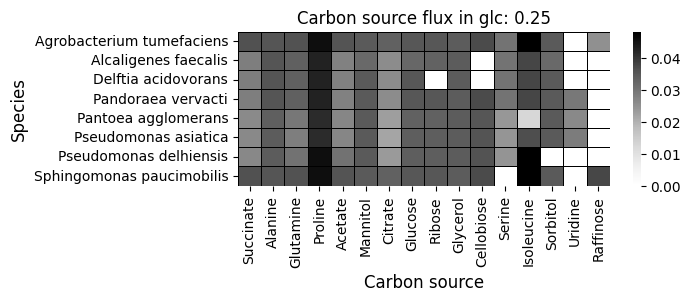

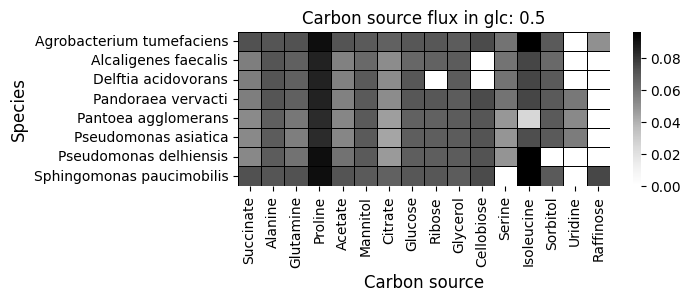

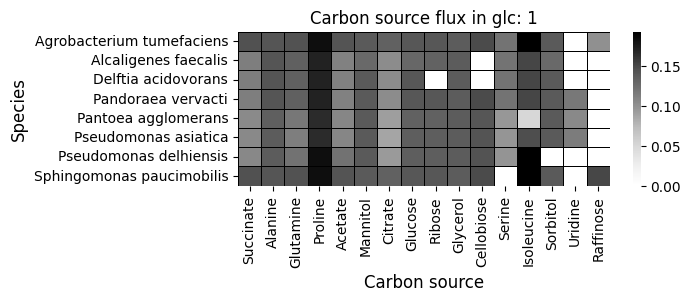

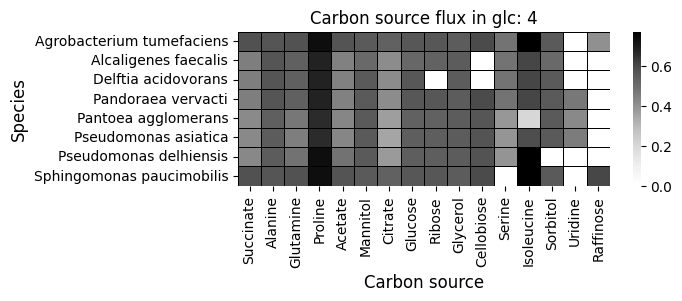

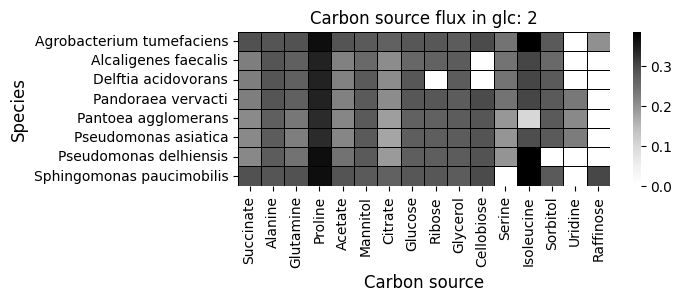

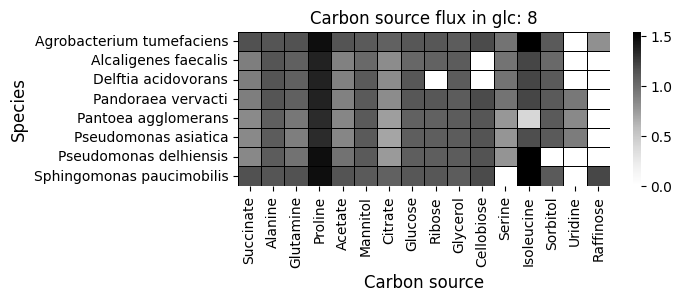

In [12]:
# Visualization
for i in np.arange(len(glc_flux_list)):
    my_csflx = glc_flux_list[i]
    my_df = copy.deepcopy(gr_df)

    my_df = my_df[my_df["cs_flux"] == my_csflx]
    my_df.pop("cs_flux")
    my_df.index = my_df["species"]
    my_df.pop("species")

    fig, ax = plt.subplots(figsize=(6, 2))
    sns.heatmap(my_df, cmap="Grays", linewidth=.5, linecolor="Black", ax=ax)
    ax.set_title("Carbon source flux in glc: " + str(my_csflx))
    ax.set_xlabel("Carbon source", fontsize=12)
    ax.set_ylabel("Species", fontsize=12)

    plt.show()

In [13]:
# Load Fig. S1
exp_gr_df = pd.read_csv("data_figs1.csv", sep="\t")
exp_gr_df

my_df = pd.DataFrame({
    "species": np.repeat(species, len(carbons)),
    "carbon": np.tile(carbons, len(species))
})

my_df["growthability"] = 0

for i in np.arange(len(my_df)):
    sp = my_df["species"][i]
    ca = my_df["carbon"][i]
    my_max = np.max(exp_gr_df.loc[(exp_gr_df["species"] == sp), ca])
    if my_max > 0:
        my_df.loc[i, "growthability"] = 1

exp_gr_sm_df = my_df
exp_gr_sm_df

,species,carbon,growthability
0,Agrobacterium tumefaciens,Succinate,1
1,Agrobacterium tumefaciens,Alanine,1
2,Agrobacterium tumefaciens,Glutamine,0
3,Agrobacterium tumefaciens,Proline,0
4,Agrobacterium tumefaciens,Acetate,1
...,...,...,...
123,Sphingomonas paucimobilis,Serine,0
124,Sphingomonas paucimobilis,Isoleucine,1
125,Sphingomonas paucimobilis,Sorbitol,0
126,Sphingomonas paucimobilis,Uridine,0


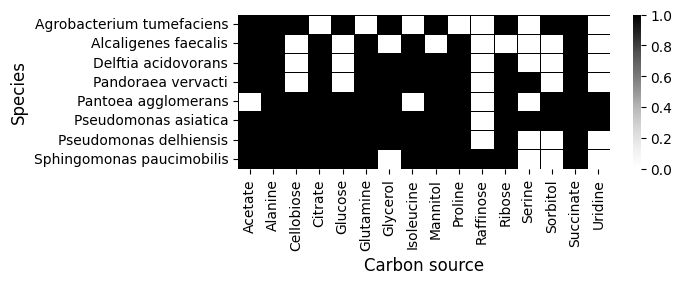

In [14]:
my_df_pivot = exp_gr_sm_df
my_df_pivot = my_df_pivot.pivot_table(
    index='species', 
    columns='carbon', 
    values='growthability'
)  # from long-format to wide

fig, ax = plt.subplots(figsize=(6, 2))
sns.heatmap(
    my_df_pivot,
    cmap="Grays",
    linewidth=0.5,
    linecolor="Black",
    ax=ax
)
ax.set_xlabel("Carbon source", fontsize=12)
ax.set_ylabel("Species", fontsize=12)
plt.show()

# Metabolites involved in nonzero flux reactions

In [15]:
nzfmtb_df = pd.concat(nzfmtb_all_models)
nzfmtb_df = nzfmtb_df.reset_index(drop=True)

first_column = nzfmtb_df.pop('species')
nzfmtb_df.insert(0, 'species', first_column)

nzfmtb_df = pd.merge(nzfmtb_df, mtb_df, how="left", on="metabolite")

essnzfmtb_df = nzfmtb_df[nzfmtb_df["essentiality"] == "Ess"]
nesnzfmtb_df = nzfmtb_df[nzfmtb_df["essentiality"] == "Nes"]

nzfmtb_df

,species,metabolite,reaction,carbon,essentiality,cs_flux,name,formula,carbon_atom
0,Agrobacterium tumefaciens,ca2_e,EX_ca2_e,Succinate,Ess,0.25,Calcium,Ca,Absence
1,Agrobacterium tumefaciens,cl_e,EX_cl_e,Succinate,Ess,0.25,Chloride,Cl,Absence
2,Agrobacterium tumefaciens,cobalt2_e,EX_cobalt2_e,Succinate,Ess,0.25,Co2+,Co,Absence
3,Agrobacterium tumefaciens,cu2_e,EX_cu2_e,Succinate,Ess,0.25,Copper,Cu,Absence
4,Agrobacterium tumefaciens,fe2_e,EX_fe2_e,Succinate,Nes,0.25,Fe2+ mitochondria,Fe,Absence
...,...,...,...,...,...,...,...,...,...
970637,Sphingomonas paucimobilis,succ_c,SHSL4r,Raffinose,Nes,8.00,Succinate,C4H4O4,Presence
970638,Sphingomonas paucimobilis,thr__L_c,THRD_L_1,Raffinose,Nes,8.00,L-Threonine,C4H9NO3,Presence
970639,Sphingomonas paucimobilis,2obut_c,THRD_L_1,Raffinose,Nes,8.00,2-Oxobutanoate,C4H5O3,Presence
970640,Sphingomonas paucimobilis,h_c,THRD_L_1,Raffinose,Nes,8.00,H+,H,Absence


In [16]:
# nonzero flux metabolites containing carbon atoms
nzfmtb_ca_df = nzfmtb_df[nzfmtb_df["carbon_atom"] == "Presence"]
nzfmtb_ca_df = nzfmtb_ca_df.reset_index(drop=True)

nzfmtb_ca_df

,species,metabolite,reaction,carbon,essentiality,cs_flux,name,formula,carbon_atom
0,Agrobacterium tumefaciens,succ_e,EX_succ_e,Succinate,Ess,0.25,Succinate,C4H4O4,Presence
1,Agrobacterium tumefaciens,2agpg160_p,2AGPG160tipp,Succinate,Nes,0.25,2-Acyl-sn-glycero-3-phosphoglycerol (n-C16:0),C22H44O9P,Presence
2,Agrobacterium tumefaciens,2agpg160_c,2AGPG160tipp,Succinate,Nes,0.25,2-Acyl-sn-glycero-3-phosphoglycerol (n-C16:0),C22H44O9P,Presence
3,Agrobacterium tumefaciens,2agpg160_c,2AGPGAT160,Succinate,Nes,0.25,2-Acyl-sn-glycero-3-phosphoglycerol (n-C16:0),C22H44O9P,Presence
4,Agrobacterium tumefaciens,atp_c,2AGPGAT160,Succinate,Nes,0.25,ATP C10H12N5O13P3,C10H12N5O13P3,Presence
...,...,...,...,...,...,...,...,...,...
681351,Sphingomonas paucimobilis,suchms_c,SHSL4r,Raffinose,Nes,8.00,O-Succinyl-L-homoserine,C8H12NO6,Presence
681352,Sphingomonas paucimobilis,2obut_c,SHSL4r,Raffinose,Nes,8.00,2-Oxobutanoate,C4H5O3,Presence
681353,Sphingomonas paucimobilis,succ_c,SHSL4r,Raffinose,Nes,8.00,Succinate,C4H4O4,Presence
681354,Sphingomonas paucimobilis,thr__L_c,THRD_L_1,Raffinose,Nes,8.00,L-Threonine,C4H9NO3,Presence


## Count the number of metabolites in each condition

In [17]:
mtb_count_list = []

my_array = {
    "species": np.repeat(species, len(carbons)),
    "carbon": np.tile(carbons, len(species))
}
my_df = pd.DataFrame(my_array)
my_df["number_nzfmtb_ca"] = np.nan

for i in np.arange(len(glc_flux_list)):
    mtb_count = copy.deepcopy(my_df)
    mtb_count["cs_flux"] = glc_flux_list[i]
    mtb_count_list.append(mtb_count)

mtb_count_table = pd.concat(mtb_count_list)
mtb_count_table = mtb_count_table.reset_index(drop=True)

mtb_count_table = pd.merge(
    mtb_count_table,
    gr_melted,
    how="left",
    on=["species", "cs_flux", "carbon"]
)

for my_sp, my_cb, my_csflx, my_i in tzip(
    mtb_count_table["species"],
    mtb_count_table["carbon"],
    mtb_count_table["cs_flux"],
    np.arange(len(mtb_count_table))
):
    my_df = nzfmtb_ca_df[
        (nzfmtb_ca_df["species"] == my_sp) &
        (nzfmtb_ca_df["carbon"] == my_cb) &
        (nzfmtb_ca_df["cs_flux"] == my_csflx)
    ]
    if len(my_df) > 0:
        my_df = my_df.drop_duplicates(subset="name")
        mtb_count_table.loc[my_i, "number_nzfmtb_ca"] = len(my_df)
        
# remove nongrowth data
mtb_count_table.loc[mtb_count_table["growth"] == 0, "number_nzfmtb_ca"] = np.nan

mtb_count_table = pd.merge(
    mtb_count_table,
    carbon_rank_df,
    how="left",
    on="carbon"
)

mtb_count_table = pd.merge(
    mtb_count_table,
    exp_gr_sm_df,
    how="left",
    on=["species", "carbon"]
)

mtb_count_table

  0%|          | 0/768 [00:00<?, ?it/s]

,species,carbon,number_nzfmtb_ca,cs_flux,growth,theta_rank,growthability
0,Agrobacterium tumefaciens,Succinate,273.0,0.25,0.036379,0,1
1,Agrobacterium tumefaciens,Alanine,272.0,0.25,0.035547,1,1
2,Agrobacterium tumefaciens,Glutamine,278.0,0.25,0.036117,2,0
3,Agrobacterium tumefaciens,Proline,288.0,0.25,0.045845,3,0
4,Agrobacterium tumefaciens,Acetate,287.0,0.25,0.035760,4,1
...,...,...,...,...,...,...,...
763,Sphingomonas paucimobilis,Serine,NaN,8.00,0.000000,11,0
764,Sphingomonas paucimobilis,Isoleucine,280.0,8.00,1.545189,12,1
765,Sphingomonas paucimobilis,Sorbitol,283.0,8.00,1.112600,13,0
766,Sphingomonas paucimobilis,Uridine,NaN,8.00,0.000000,14,0


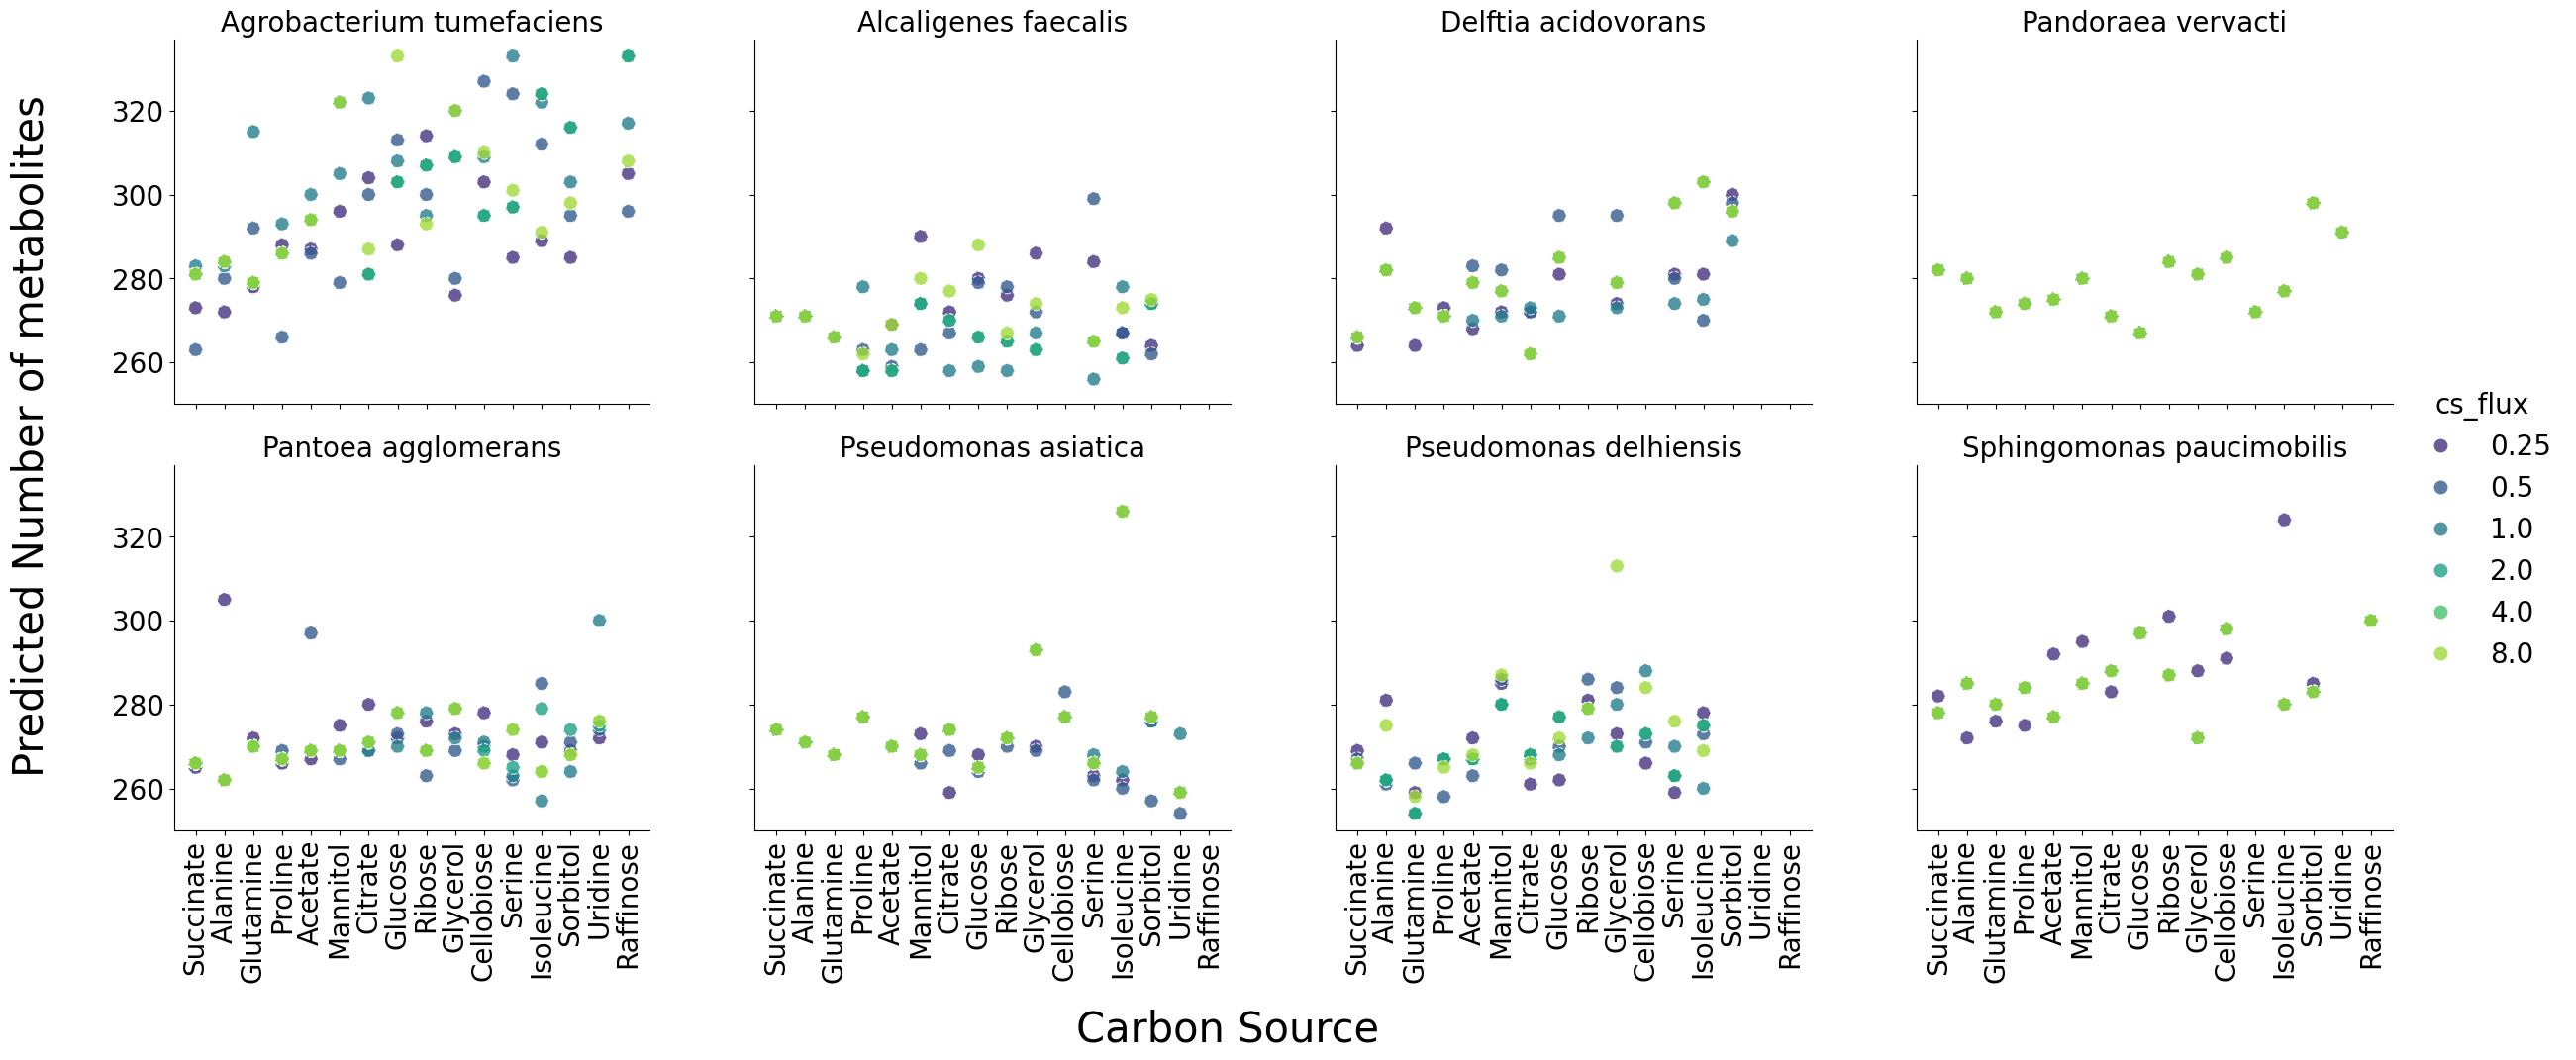

In [18]:
# Visualization
with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=mtb_count_table,
        x="carbon",
        y="number_nzfmtb_ca",
        hue=mtb_count_table["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.tick_params(axis='x', rotation=90)
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(
        0.06,
        0.5,
        "Predicted Number of metabolites",
        va="center",
        rotation='vertical',
        fontsize=30
    )
    g.fig.text(
        0.45,
        -0.1,
        "Carbon Source",
        va="center",
        fontsize=30
    )
    plt.show()

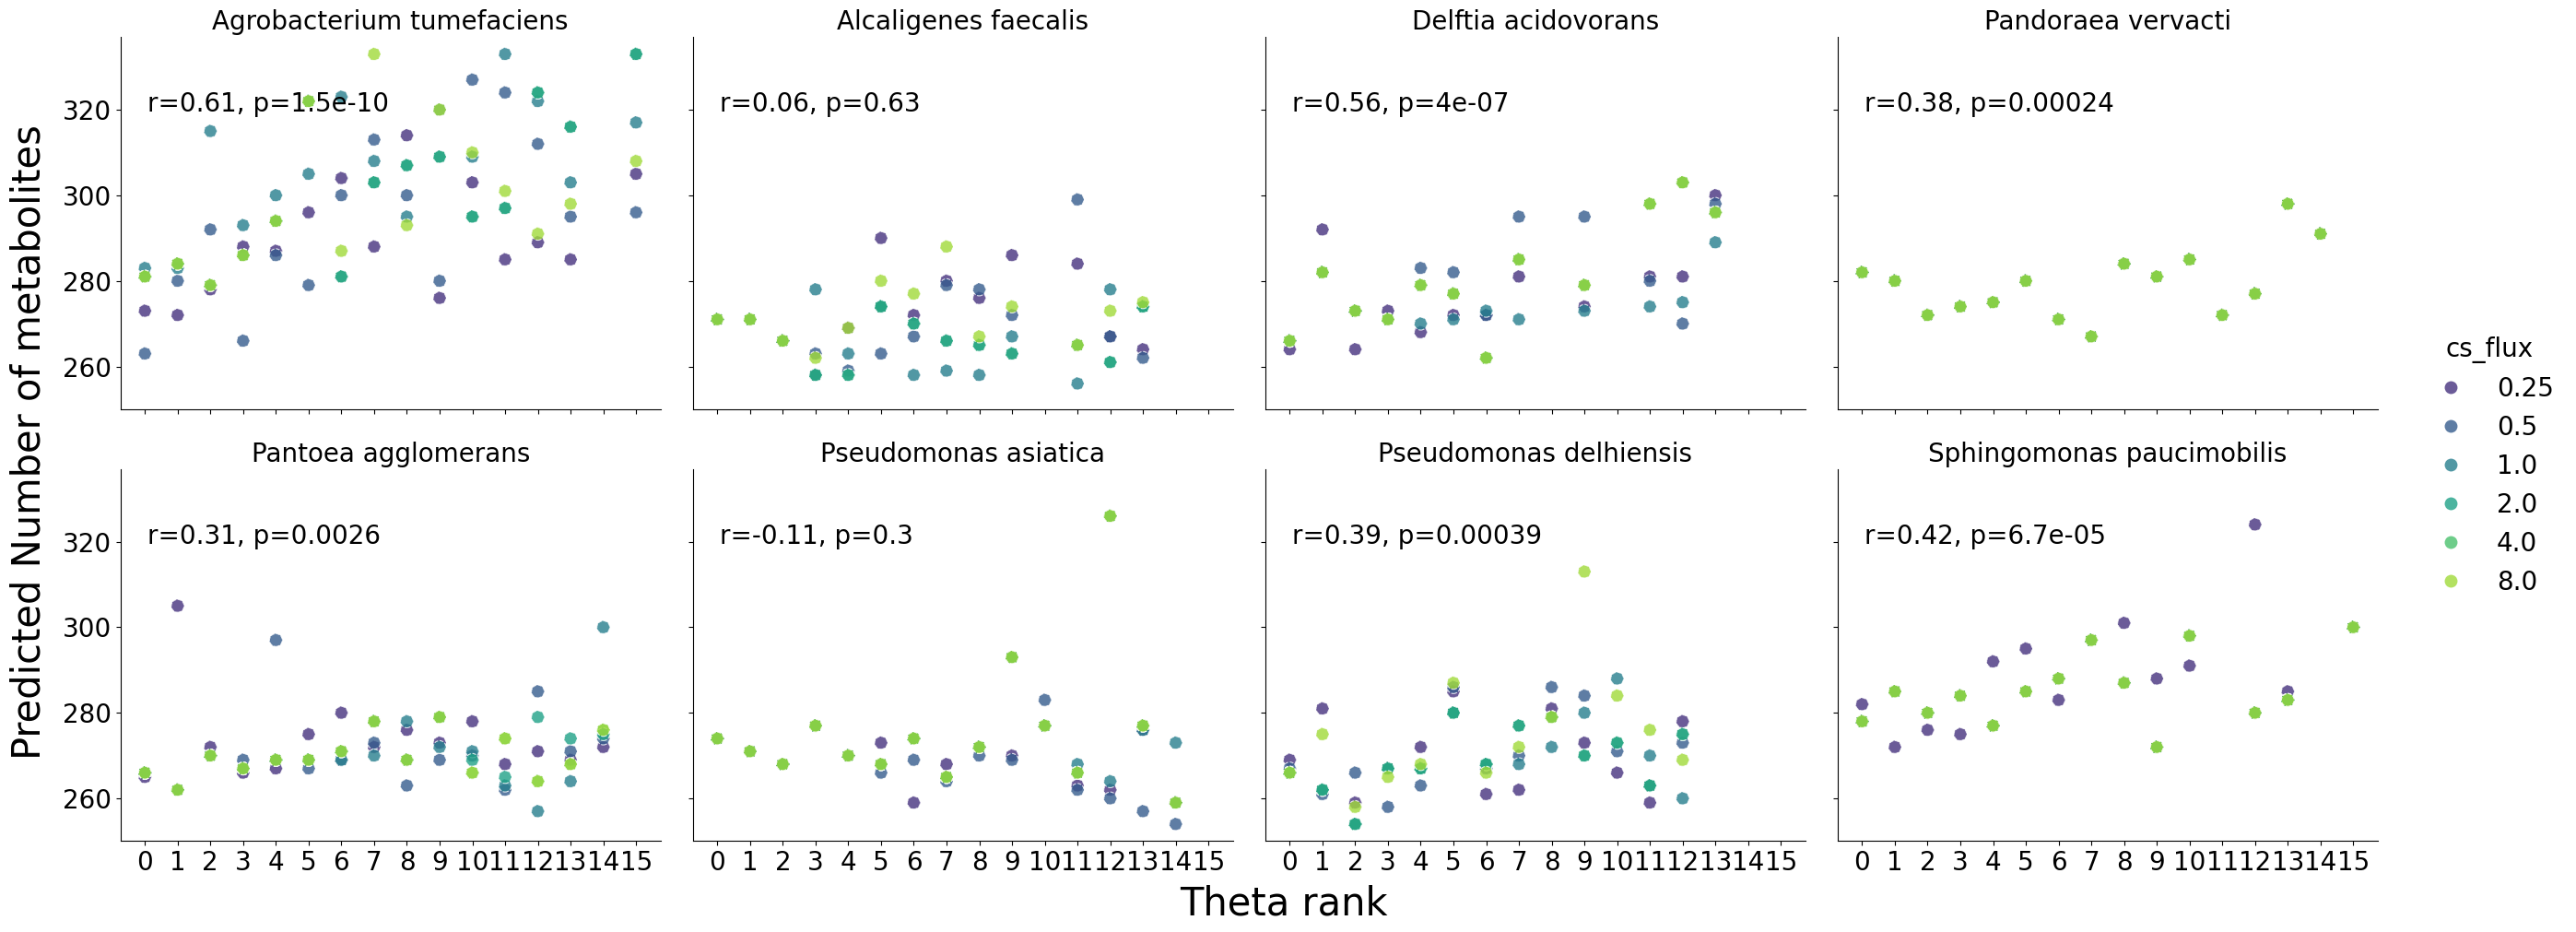

In [19]:
# Visualization
def annotate(data, **kws):
    r, p = spearmanr(data['theta_rank'], data['number_nzfmtb_ca'], nan_policy="omit")
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=mtb_count_table,
        x="theta_rank",
        y="number_nzfmtb_ca",
        hue=mtb_count_table["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.set(xticks=np.arange(len(carbons)))
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(-0.01, 0.5, "Predicted Number of metabolites",
               va="center", rotation='vertical', fontsize=30)
    g.fig.text(0.45, 0, "Theta rank", va="center", fontsize=30)
    g.map_dataframe(annotate)
    plt.show()

/var/folders/7b/csf8mnvs2h93h1d_rngc2nkh0000gn/T/ipykernel_39717/4649016.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


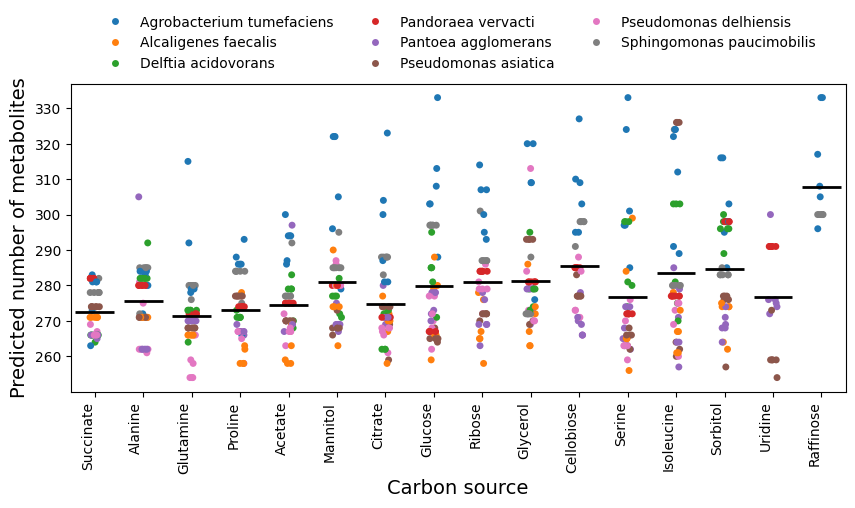

In [20]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 4))

sns.stripplot(
    data=mtb_count_table,
    x="carbon",
    y="number_nzfmtb_ca",
    hue="species"
)

sns.boxplot(
    showmeans=True,
    meanline=True,
    meanprops={'color': 'k', 'ls': '-', 'lw': 2},
    medianprops={'visible': False},
    whiskerprops={'visible': False},
    zorder=10,
    x="carbon",
    y="number_nzfmtb_ca",
    data=mtb_count_table,
    showfliers=False,
    showbox=False,
    showcaps=False,
    ax=ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha="right"
)

ax.set_xlabel("Carbon source", fontsize=14)
ax.set_ylabel("Predicted number of metabolites", fontsize=14)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(.5, 1),
    ncol=3,
    title=None,
    frameon=False,
)

plt.show()

## The impact of carbon source uptake flux on the number ofmetabolites

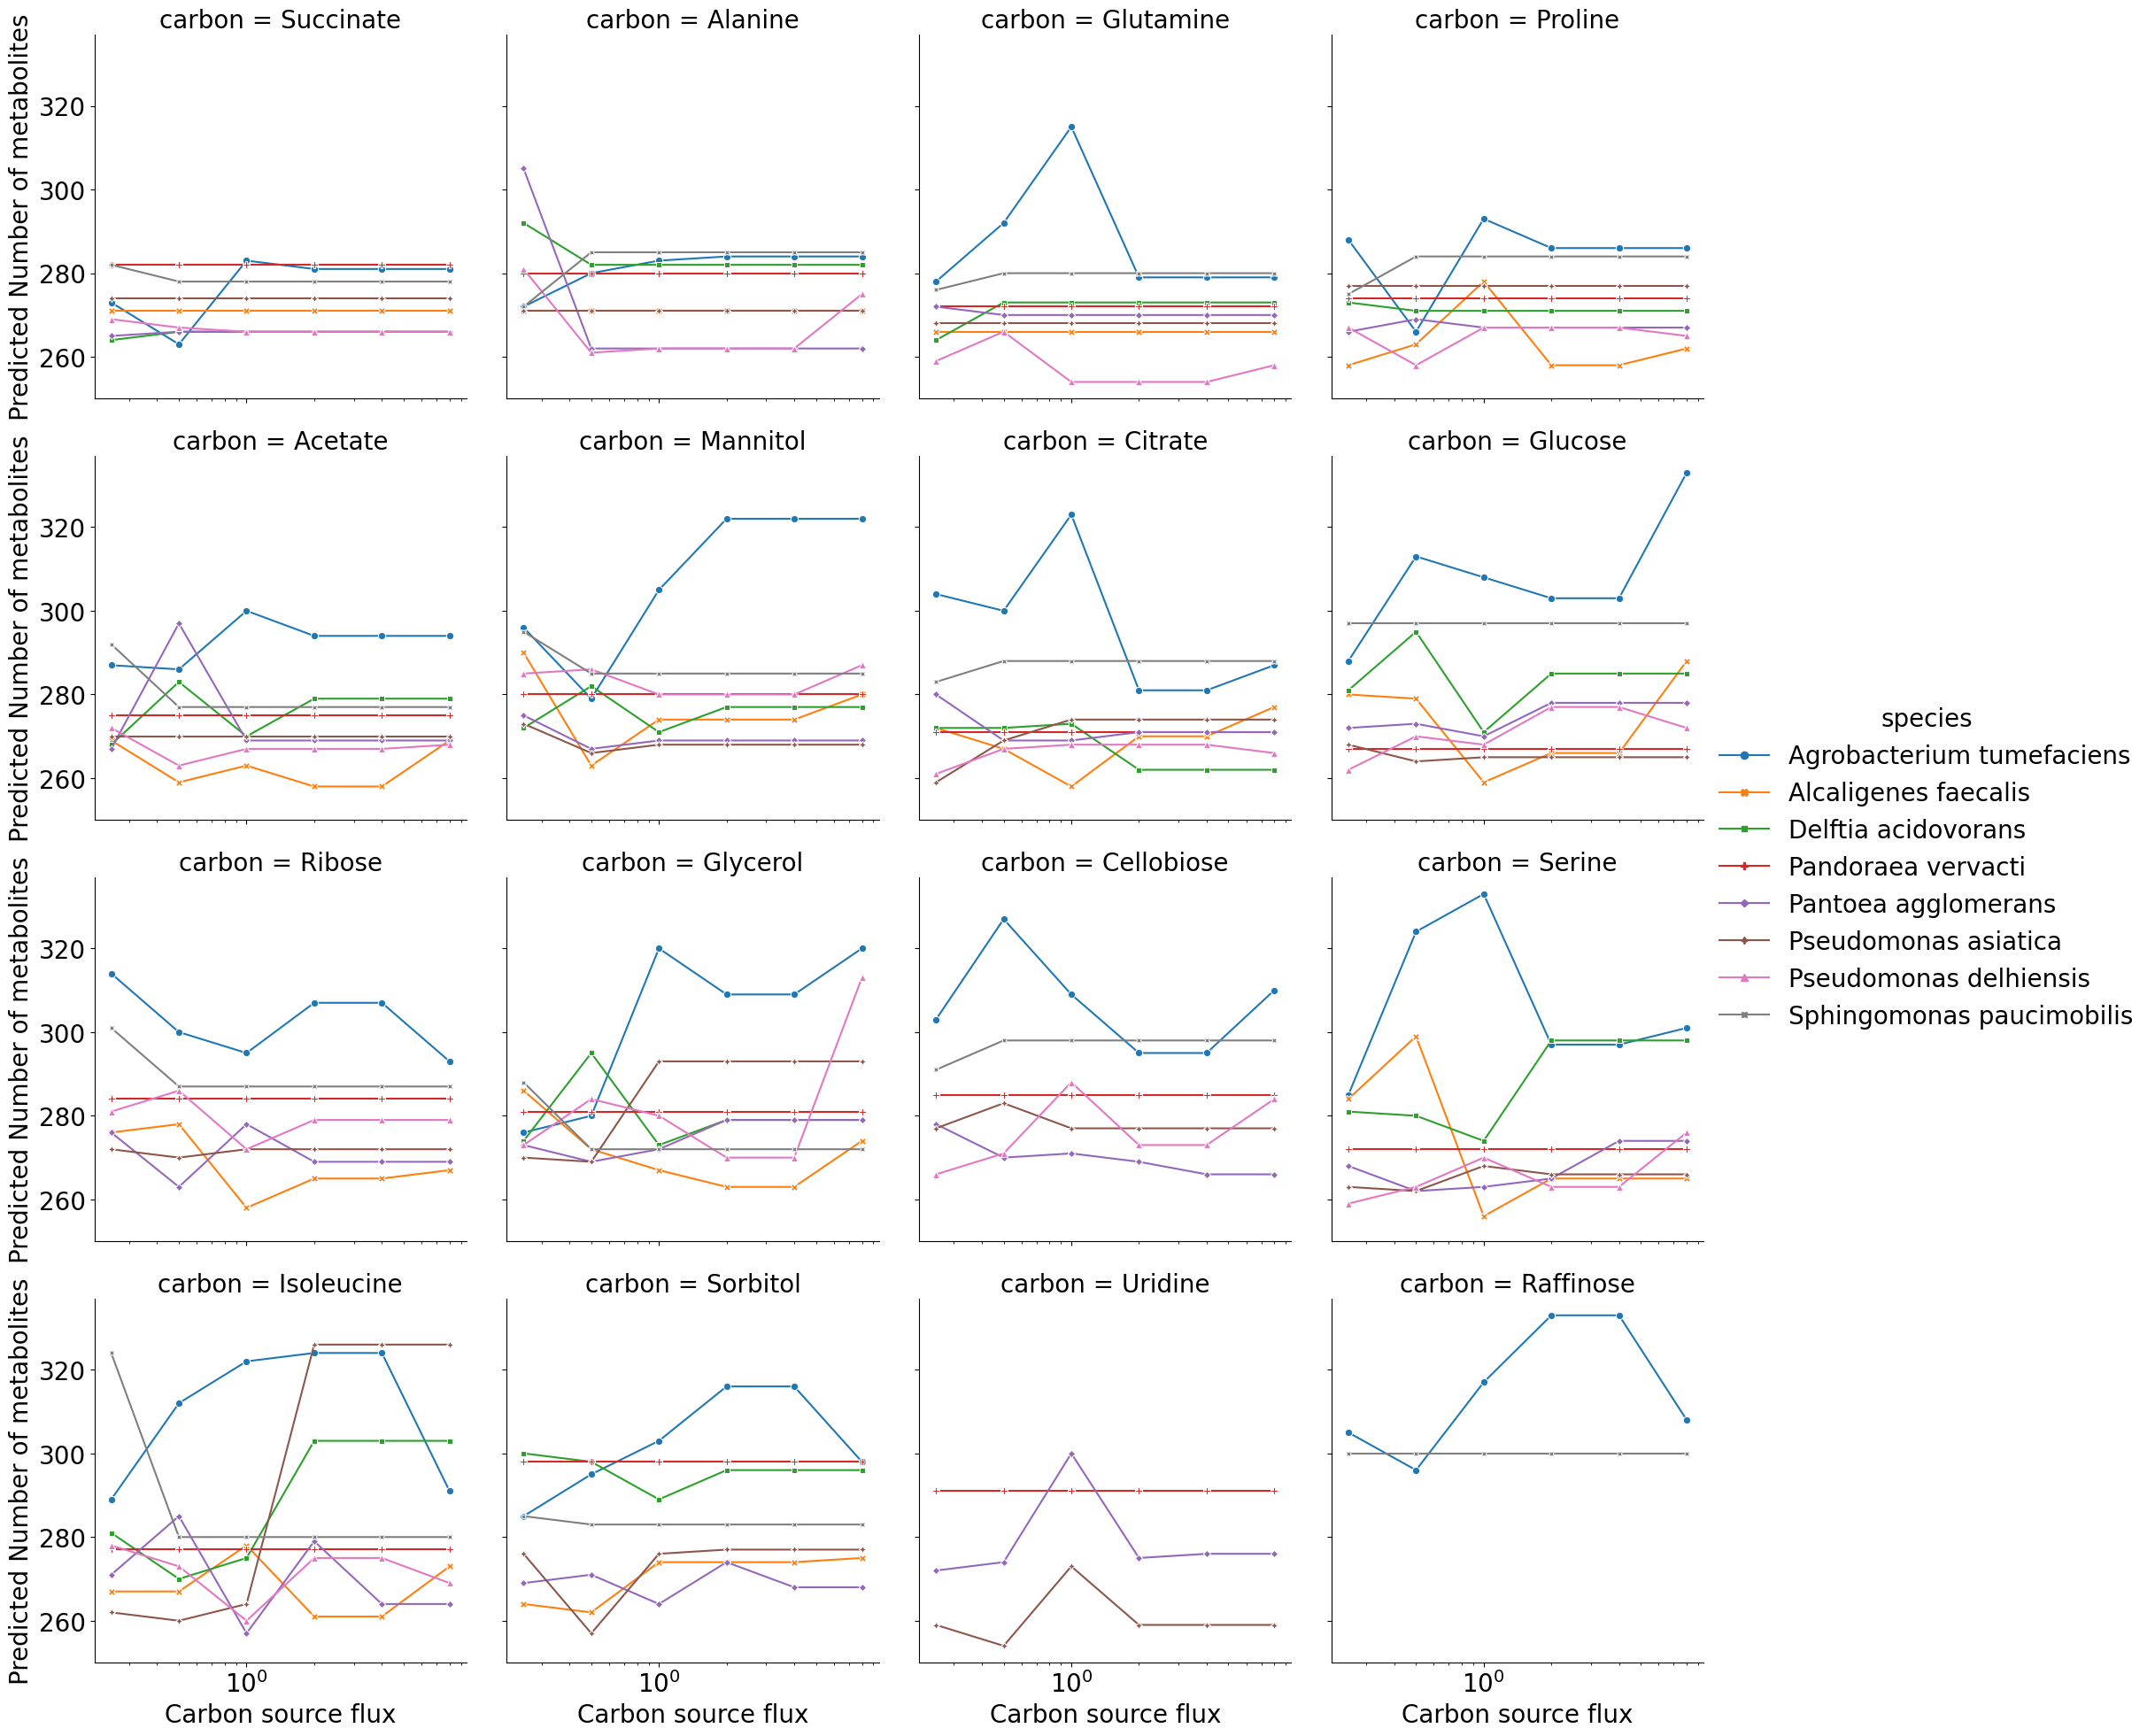

In [21]:
with sns.plotting_context(rc={'font.size': 20}):
    g = sns.relplot(
        x="cs_flux",
        y="number_nzfmtb_ca",
        data=mtb_count_table,
        kind="line",
        hue="species",
        style="species",
        markers=True,
        dashes=False,
        col="carbon",
        col_wrap=4
    )
    g.set_ylabels("Predicted Number of metabolites", clear_inner=False)
    g.set_xlabels("Carbon source flux", clear_inner=False)
    g.set(xscale="log")
    plt.show()

## Correlation analysis

In [22]:
# Correlation analysis
stat_df = pd.DataFrame({"carbon": carbons})
stat_df["theta_rank"] = stat_df.index
stat_df["median_count"] = 0.0
stat_df["mean_count"] = 0.0

for i in np.arange(len(stat_df)):
    stat_df.loc[i, "median_count"] = np.nanmedian(
        mtb_count_table[mtb_count_table["carbon"] == stat_df["carbon"][i]]["number_nzfmtb_ca"]
    )
    stat_df.loc[i, "mean_count"] = np.nanmean(
        mtb_count_table[mtb_count_table["carbon"] == stat_df["carbon"][i]]["number_nzfmtb_ca"]
    )

stat_df

print(
    spearmanr(stat_df["theta_rank"], stat_df["median_count"], alternative="two-sided")
)
print(
    spearmanr(stat_df["theta_rank"], stat_df["mean_count"], alternative="two-sided")
)

SignificanceResult(statistic=np.float64(0.5489831773921019), pvalue=np.float64(0.02763900075752781))
SignificanceResult(statistic=np.float64(0.7823529411764706), pvalue=np.float64(0.00034122076396497244))


## Count the number of "essential" metabolites in each condition

In [23]:
mtb_count_list = []

my_array = {
    "species": np.repeat(species, len(carbons)),
    "carbon": np.tile(carbons, len(species))
}

my_df = pd.DataFrame(my_array)
my_df["number_nzfmtb_ca"] = np.nan
my_df["names"] = np.nan

for i in np.arange(len(glc_flux_list)):
    mtb_count = copy.deepcopy(my_df)
    mtb_count["cs_flux"] = glc_flux_list[i]
    mtb_count_list.append(mtb_count)

essmtb_count_table = pd.concat(mtb_count_list)
essmtb_count_table = essmtb_count_table.reset_index(drop=True)
essmtb_count_table = pd.merge(
    essmtb_count_table, gr_melted, how="left", on=["species", "cs_flux", "carbon"]
)

nesmtb_count_table = copy.deepcopy(essmtb_count_table)


for my_sp, my_cb, my_csflx, my_i in tzip(
    essmtb_count_table["species"],
    essmtb_count_table["carbon"],
    essmtb_count_table["cs_flux"],
    np.arange(len(essmtb_count_table))
):
    my_df = nzfmtb_ca_df[
        (nzfmtb_ca_df["species"] == my_sp)
        & (nzfmtb_ca_df["carbon"] == my_cb)
        & (nzfmtb_ca_df["cs_flux"] == my_csflx)
        & (nzfmtb_ca_df["essentiality"] == "Ess")
    ]
    if len(my_df) > 0:
        my_df = my_df.drop_duplicates(subset="name")
        essmtb_count_table.loc[my_i, "number_nzfmtb_ca"] = len(my_df)
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            essmtb_count_table.loc[my_i, "names"] = my_df["name"].str.cat(sep=";")
        if my_i % 400 == 0:
            print(essmtb_count_table.loc[my_i, "number_nzfmtb_ca"])

    my_df = nzfmtb_ca_df[
        (nzfmtb_ca_df["species"] == my_sp)
        & (nzfmtb_ca_df["carbon"] == my_cb)
        & (nzfmtb_ca_df["cs_flux"] == my_csflx)
        & (nzfmtb_ca_df["essentiality"] == "Nes")
    ]
    if len(my_df) > 0:
        my_df = my_df.drop_duplicates(subset="name")
        nesmtb_count_table.loc[my_i, "number_nzfmtb_ca"] = len(my_df)
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            nesmtb_count_table.loc[my_i, "names"] = my_df["name"].str.cat(sep=";")


# remove nongrowth data
essmtb_count_table.loc[essmtb_count_table["growth"] == 0, "number_nzfmtb_ca"] = np.nan
nesmtb_count_table.loc[nesmtb_count_table["growth"] == 0, "number_nzfmtb_ca"] = np.nan

essmtb_count_table = pd.merge(essmtb_count_table, carbon_rank_df, how="left", on="carbon")
nesmtb_count_table = pd.merge(nesmtb_count_table, carbon_rank_df, how="left", on="carbon")

essmtb_count_table = pd.merge(
    essmtb_count_table, exp_gr_sm_df, how="left", on=["species", "carbon"]
)
nesmtb_count_table = pd.merge(
    nesmtb_count_table, exp_gr_sm_df, how="left", on=["species", "carbon"]
)

essmtb_count_table

  0%|          | 0/768 [00:00<?, ?it/s]

203.0
215.0


,species,carbon,number_nzfmtb_ca,names,cs_flux,growth,theta_rank,growthability
0,Agrobacterium tumefaciens,Succinate,203.0,Succinate;4-Hydroxy-benzyl alcohol;Nicotinamid...,0.25,0.036379,0,1
1,Agrobacterium tumefaciens,Alanine,203.0,L-Alanine;4-Hydroxy-benzyl alcohol;Nicotinamid...,0.25,0.035547,1,1
2,Agrobacterium tumefaciens,Glutamine,203.0,L-Glutamine;4-Hydroxy-benzyl alcohol;Nicotinam...,0.25,0.036117,2,0
3,Agrobacterium tumefaciens,Proline,200.0,L-Proline;4-Hydroxy-benzyl alcohol;Nicotinamid...,0.25,0.045845,3,0
4,Agrobacterium tumefaciens,Acetate,204.0,Acetate;4-Hydroxy-benzyl alcohol;Nicotinamide ...,0.25,0.035760,4,1
...,...,...,...,...,...,...,...,...
763,Sphingomonas paucimobilis,Serine,NaN,NaN,8.00,0.000000,11,0
764,Sphingomonas paucimobilis,Isoleucine,222.0,L-Isoleucine;4-Hydroxy-benzyl alcohol;Nicotina...,8.00,1.545189,12,1
765,Sphingomonas paucimobilis,Sorbitol,214.0,D-Sorbitol;4-Hydroxy-benzyl alcohol;Nicotinami...,8.00,1.112600,13,0
766,Sphingomonas paucimobilis,Uridine,NaN,NaN,8.00,0.000000,14,0


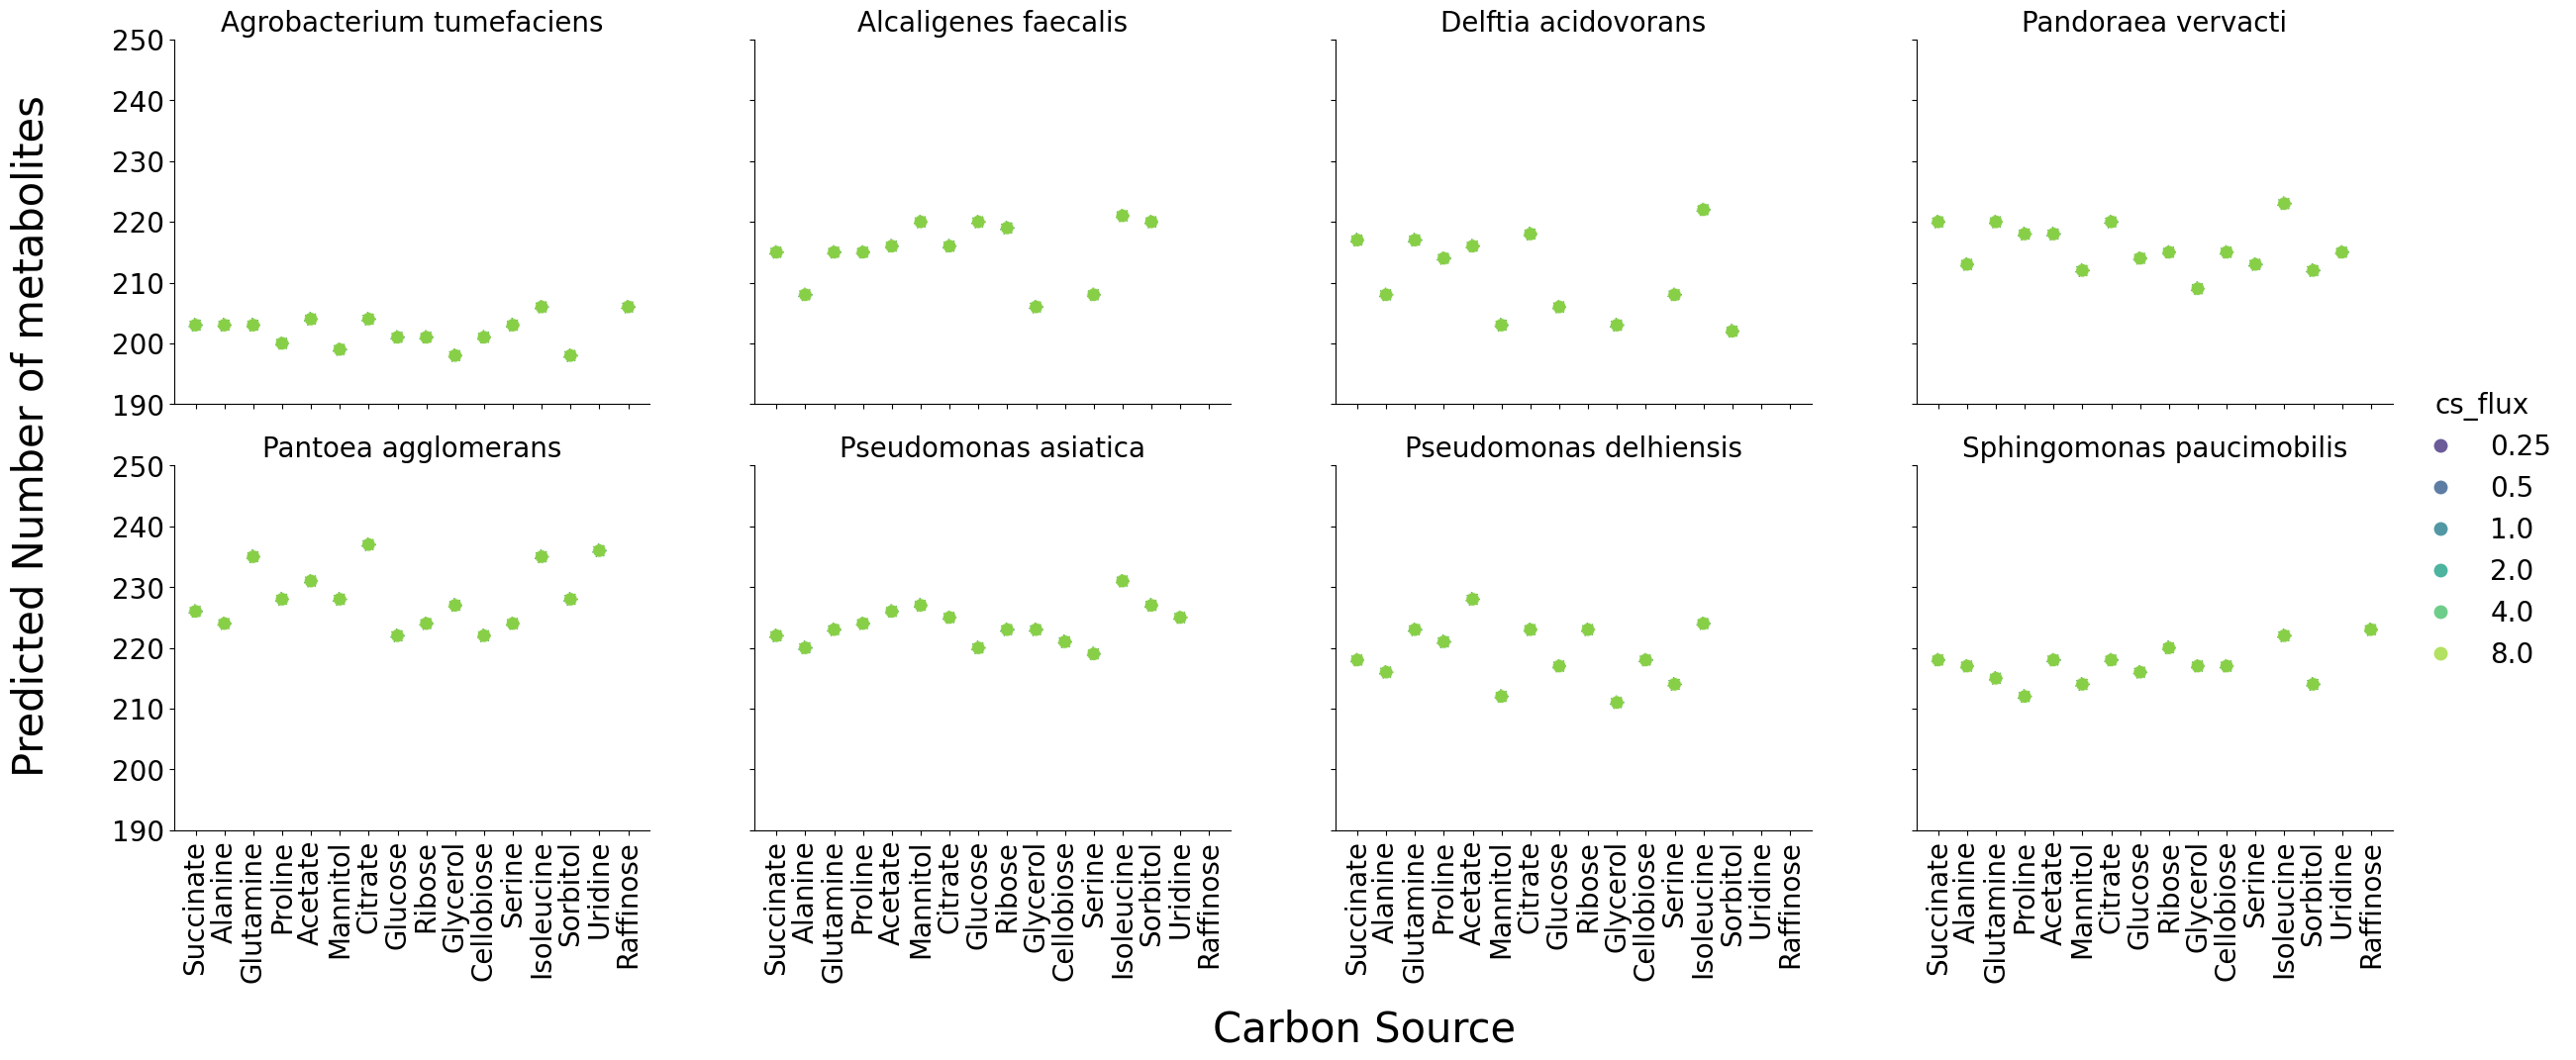

In [24]:
# Visualization Essential
my_df = copy.deepcopy(essmtb_count_table)

with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=my_df,
        x="carbon",
        y="number_nzfmtb_ca",
        hue=my_df["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.set(ylim=(190, 250))
    g.tick_params(axis='x', rotation=90)
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(0.06, 0.5, "Predicted Number of metabolites", va="center", rotation='vertical', fontsize=30)
    g.fig.text(0.5, -0.1, "Carbon Source", va="center", fontsize=30)
    plt.show()

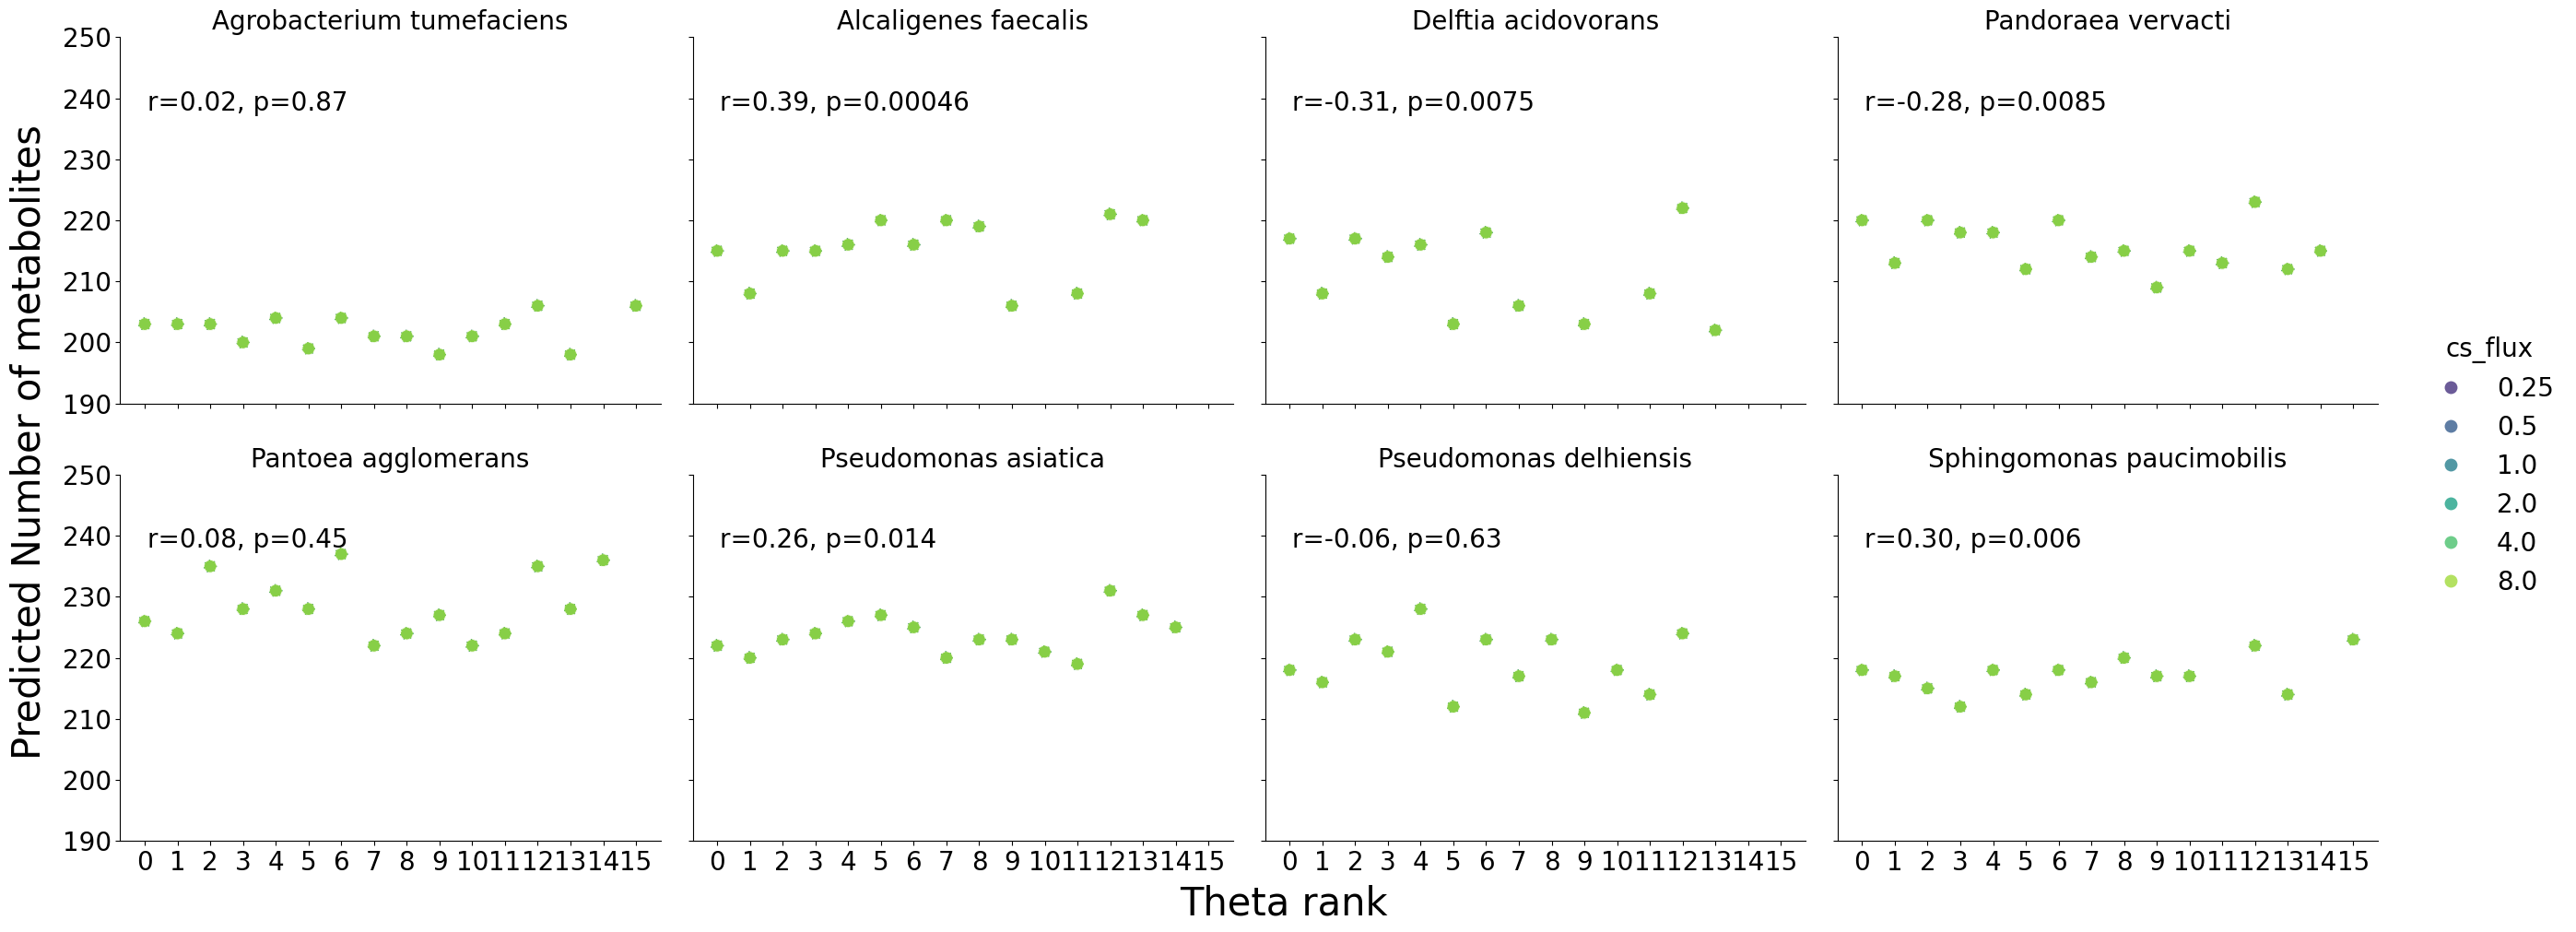

In [25]:
# Visualization Essential
my_df = copy.deepcopy(essmtb_count_table)

with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=my_df,
        x="theta_rank",
        y="number_nzfmtb_ca",
        hue=my_df["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.set(xticks=np.arange(len(carbons)), ylim=(190, 250))
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(-0.01, 0.5, "Predicted Number of metabolites", va="center", rotation='vertical', fontsize=30)
    g.fig.text(0.45, 0, "Theta rank", va="center", fontsize=30)
    g.map_dataframe(annotate)
    plt.show()

### Remove conditions where bacterial growth was not obserbed experimentally.

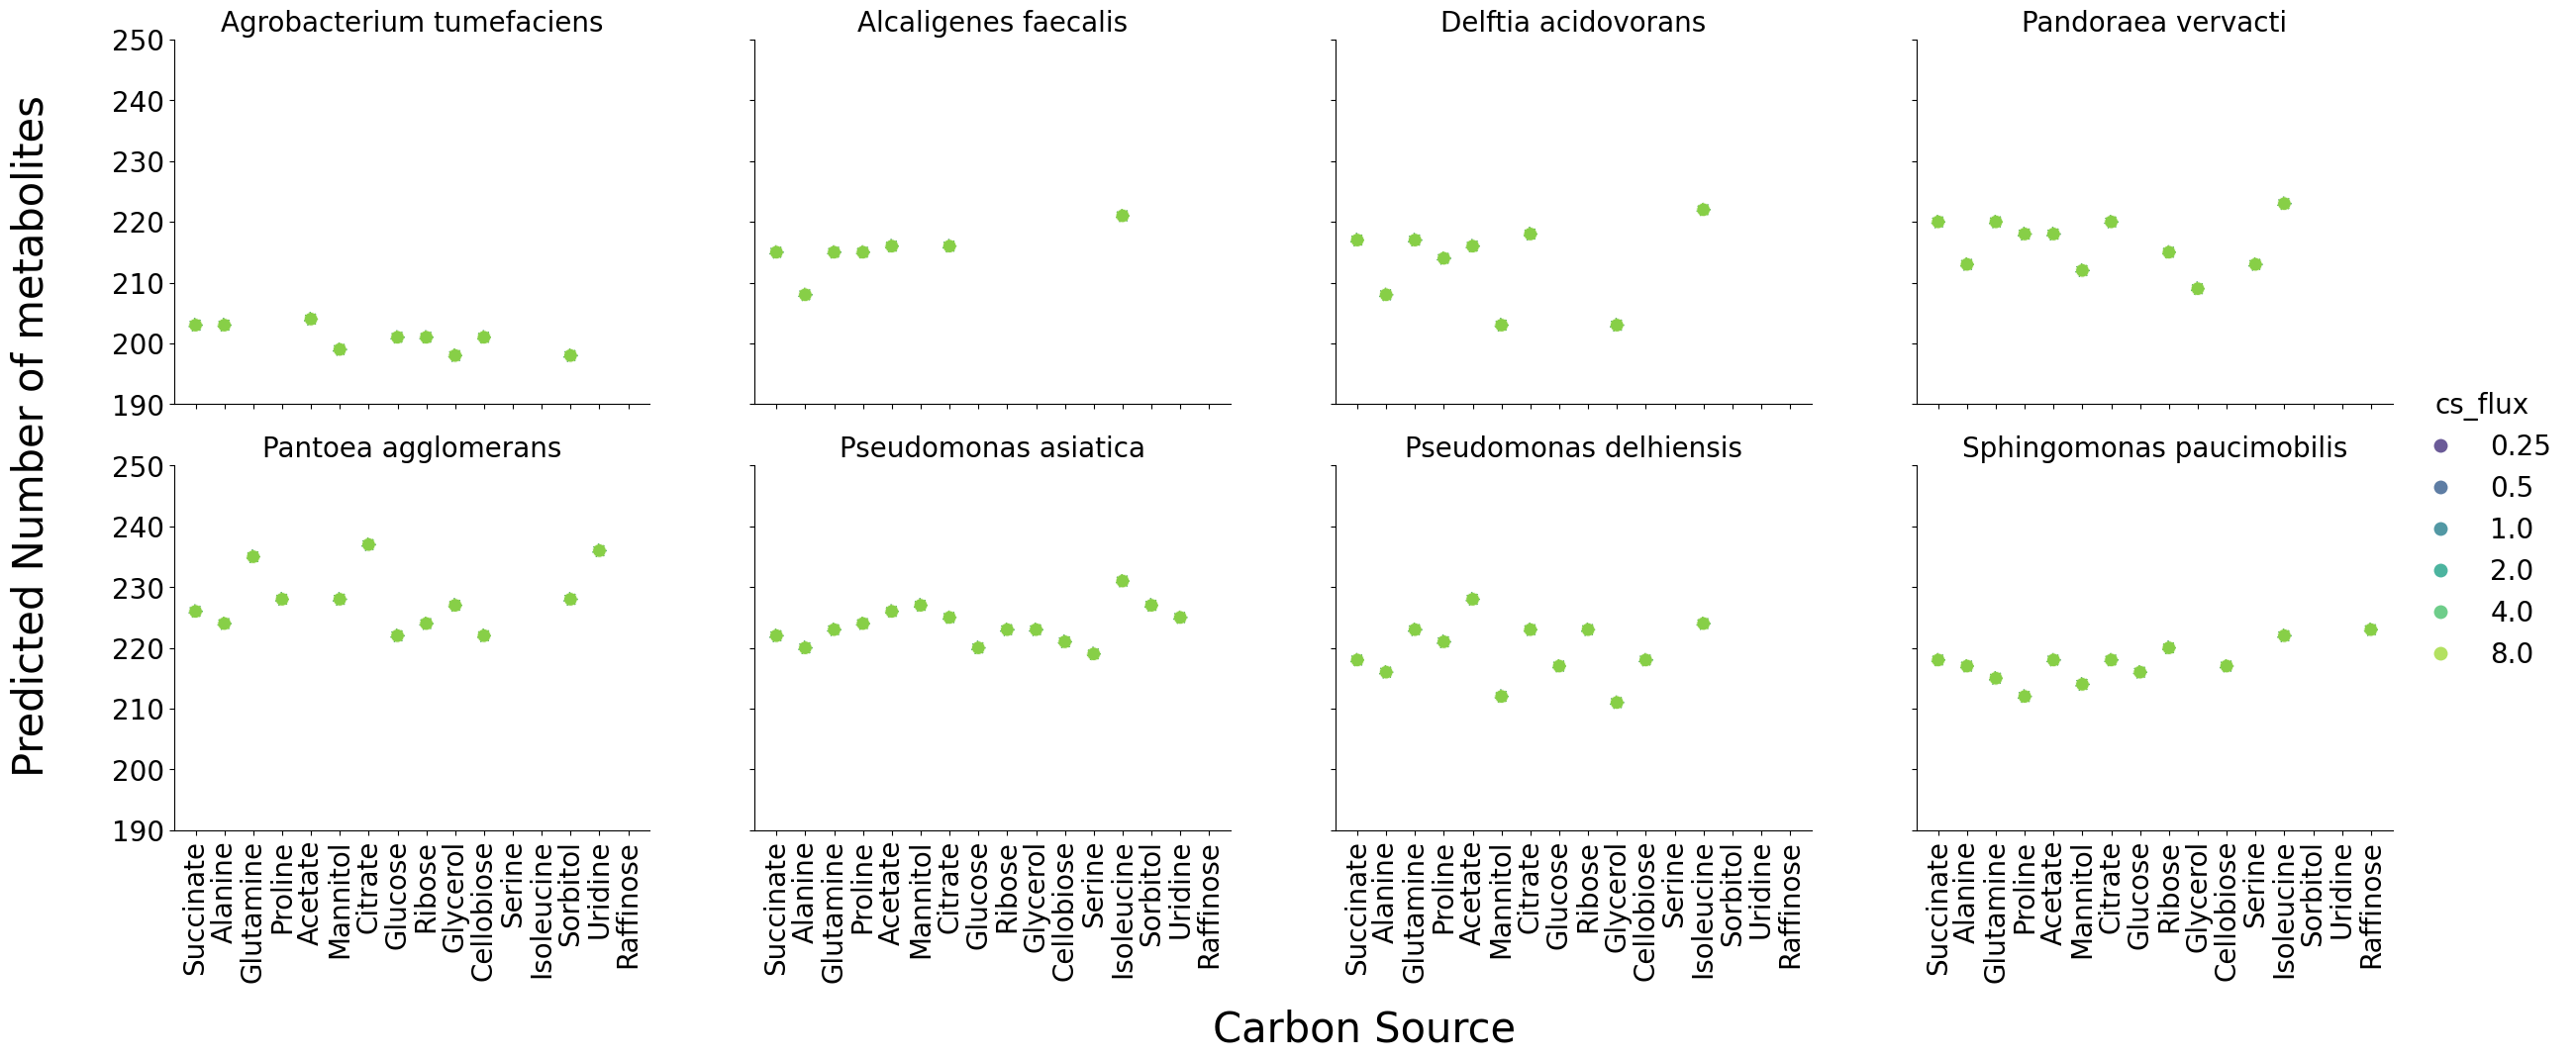

In [26]:
# Visualization Essential
my_df = copy.deepcopy(essmtb_count_table)
my_df.loc[my_df["growthability"] == 0, "number_nzfmtb_ca"] = np.nan

with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=my_df,
        x="carbon",
        y="number_nzfmtb_ca",
        hue=my_df["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.set(ylim=(190, 250))
    g.tick_params(axis='x', rotation=90)
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(0.06, 0.5, "Predicted Number of metabolites", va="center", rotation='vertical', fontsize=30)
    g.fig.text(0.5, -0.1, "Carbon Source", va="center", fontsize=30)

    plt.show()

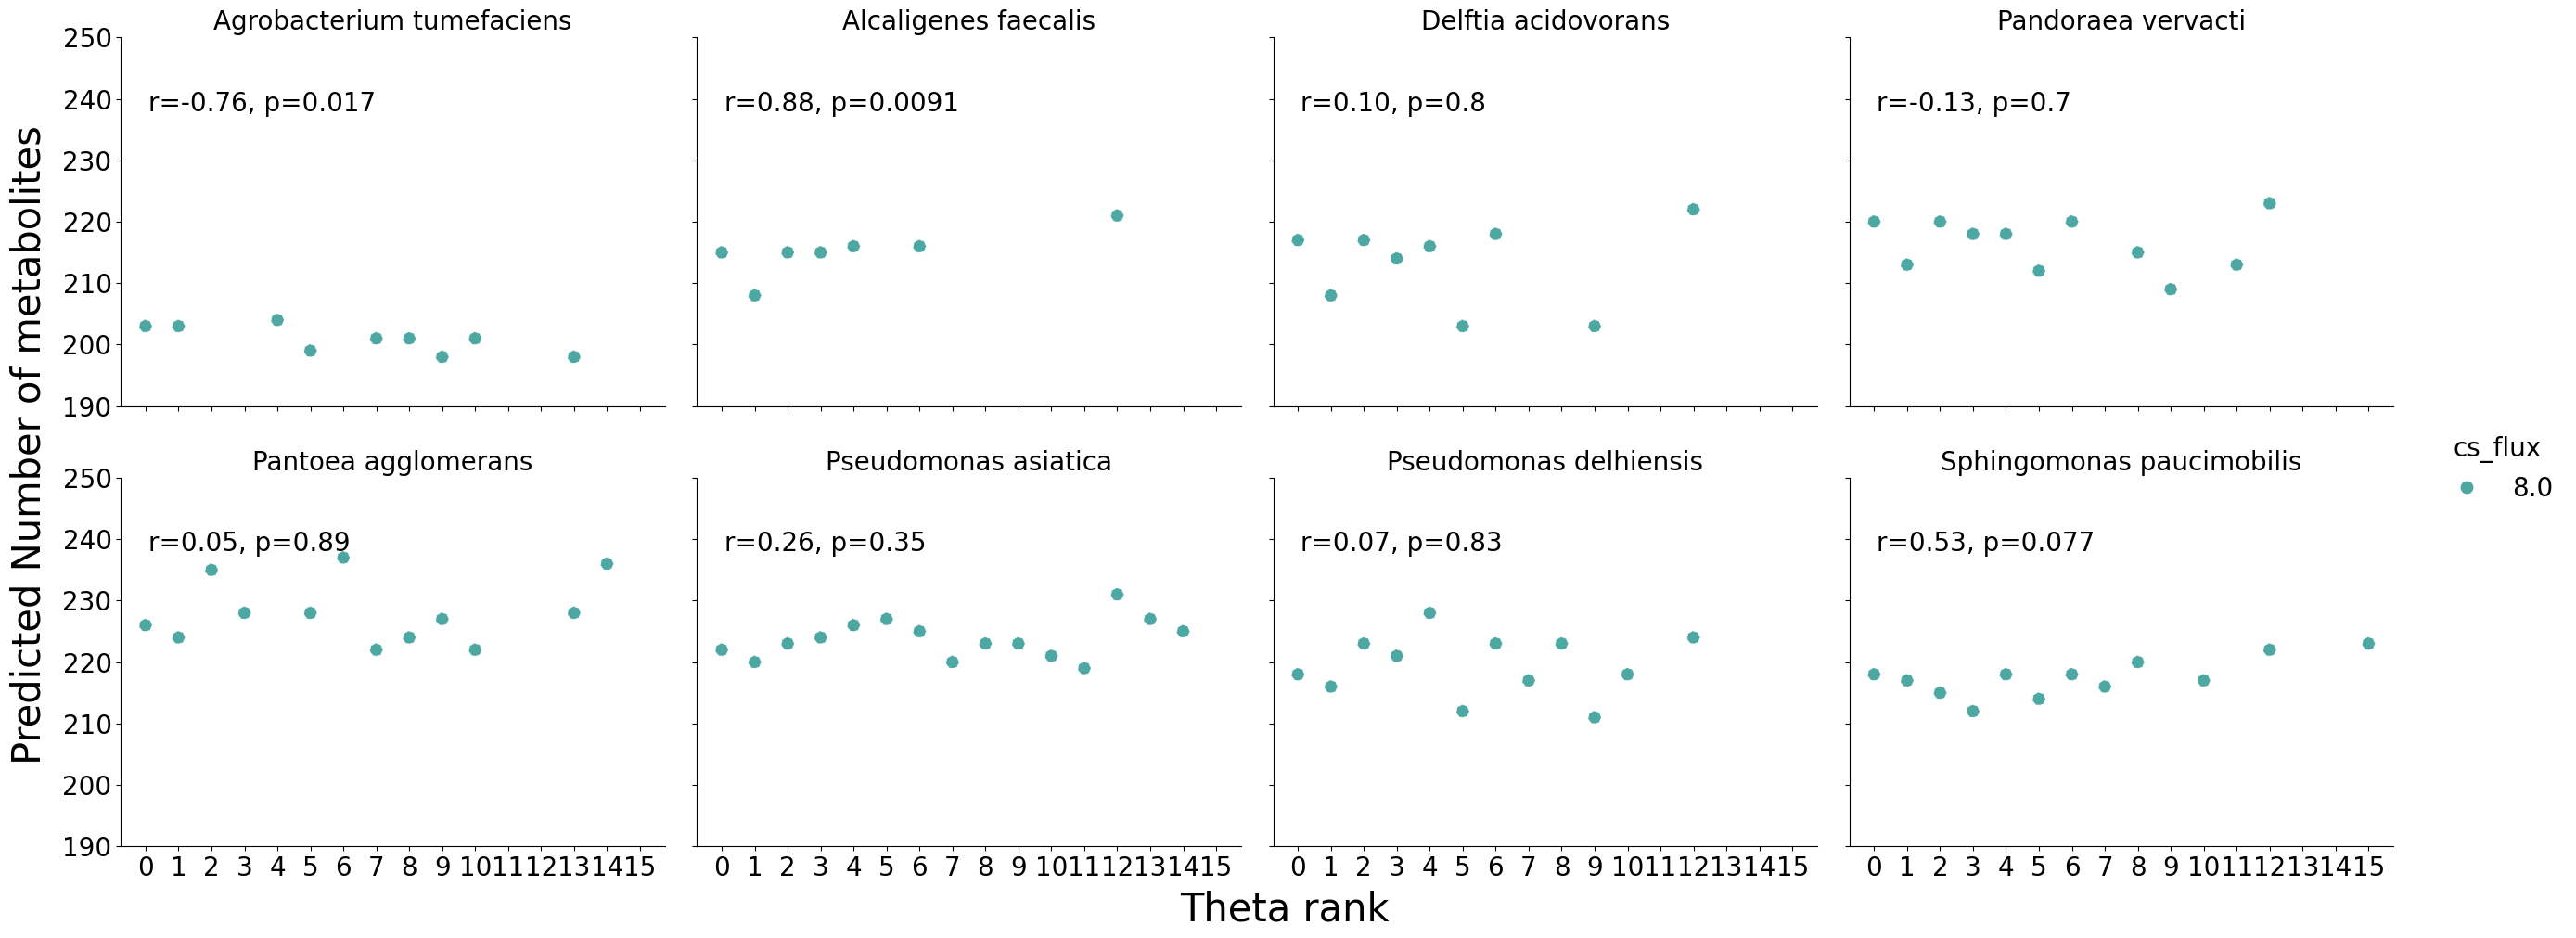

In [27]:
# Visualization Essential
my_df = copy.deepcopy(essmtb_count_table)
my_df.loc[my_df["growthability"] == 0, "number_nzfmtb_ca"] = np.nan
my_df = my_df[my_df["cs_flux"] == 8]

with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=my_df,
        x="theta_rank",
        y="number_nzfmtb_ca",
        hue=my_df["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.set(
        xticks=np.arange(len(carbons)),
        ylim=(190, 250)
    )
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(-0.01, 0.5, "Predicted Number of metabolites", va="center", rotation='vertical', fontsize=30)
    g.fig.text(0.45, 0, "Theta rank", va="center", fontsize=30)
    g.map_dataframe(annotate)
    plt.show()

## Count the number of "nonessential" metabolites in each condition

In [28]:
nesspmtb_count_table = copy.deepcopy(nesmtb_count_table)

for i in np.arange(len(nesspmtb_count_table)):
    if nesspmtb_count_table["growth"][i] > 0:
        my_ess = essmtb_count_table["names"][i].split(";")
        my_nes = nesspmtb_count_table["names"][i].split(";")
        my_ess = set(my_ess)
        my_nes = set(my_nes)
        my_nes = my_nes - my_ess  # remove common metabolites between essential and nonessential reactions
        nesspmtb_count_table.loc[i, "number_nzfmtb_ca"] = len(my_nes)
        nesspmtb_count_table.loc[i, "names"] = ";".join(list(my_nes))

nesspmtb_count_table

,species,carbon,number_nzfmtb_ca,names,cs_flux,growth,theta_rank,growthability
0,Agrobacterium tumefaciens,Succinate,70.0,Xanthosine 5'-phosphate;2-Deoxy-D-ribose 1-pho...,0.25,0.036379,0,1
1,Agrobacterium tumefaciens,Alanine,69.0,Xanthosine 5'-phosphate;2-Deoxy-D-ribose 1-pho...,0.25,0.035547,1,1
2,Agrobacterium tumefaciens,Glutamine,75.0,Xanthosine 5'-phosphate;2-Deoxy-D-ribose 1-pho...,0.25,0.036117,2,0
3,Agrobacterium tumefaciens,Proline,88.0,2-Deoxy-D-ribose 1-phosphate;DADP C10H12N5O9P2...,0.25,0.045845,3,0
4,Agrobacterium tumefaciens,Acetate,83.0,2-Deoxy-D-ribose 1-phosphate;DADP C10H12N5O9P2...,0.25,0.035760,4,1
...,...,...,...,...,...,...,...,...
763,Sphingomonas paucimobilis,Serine,NaN,NaN,8.00,0.000000,11,0
764,Sphingomonas paucimobilis,Isoleucine,58.0,"3,4-Dihydroxybenzoate;Xanthosine 5'-phosphate;...",8.00,1.545189,12,1
765,Sphingomonas paucimobilis,Sorbitol,69.0,"3,4-Dihydroxybenzoate;Xanthosine 5'-phosphate;...",8.00,1.112600,13,0
766,Sphingomonas paucimobilis,Uridine,NaN,NaN,8.00,0.000000,14,0


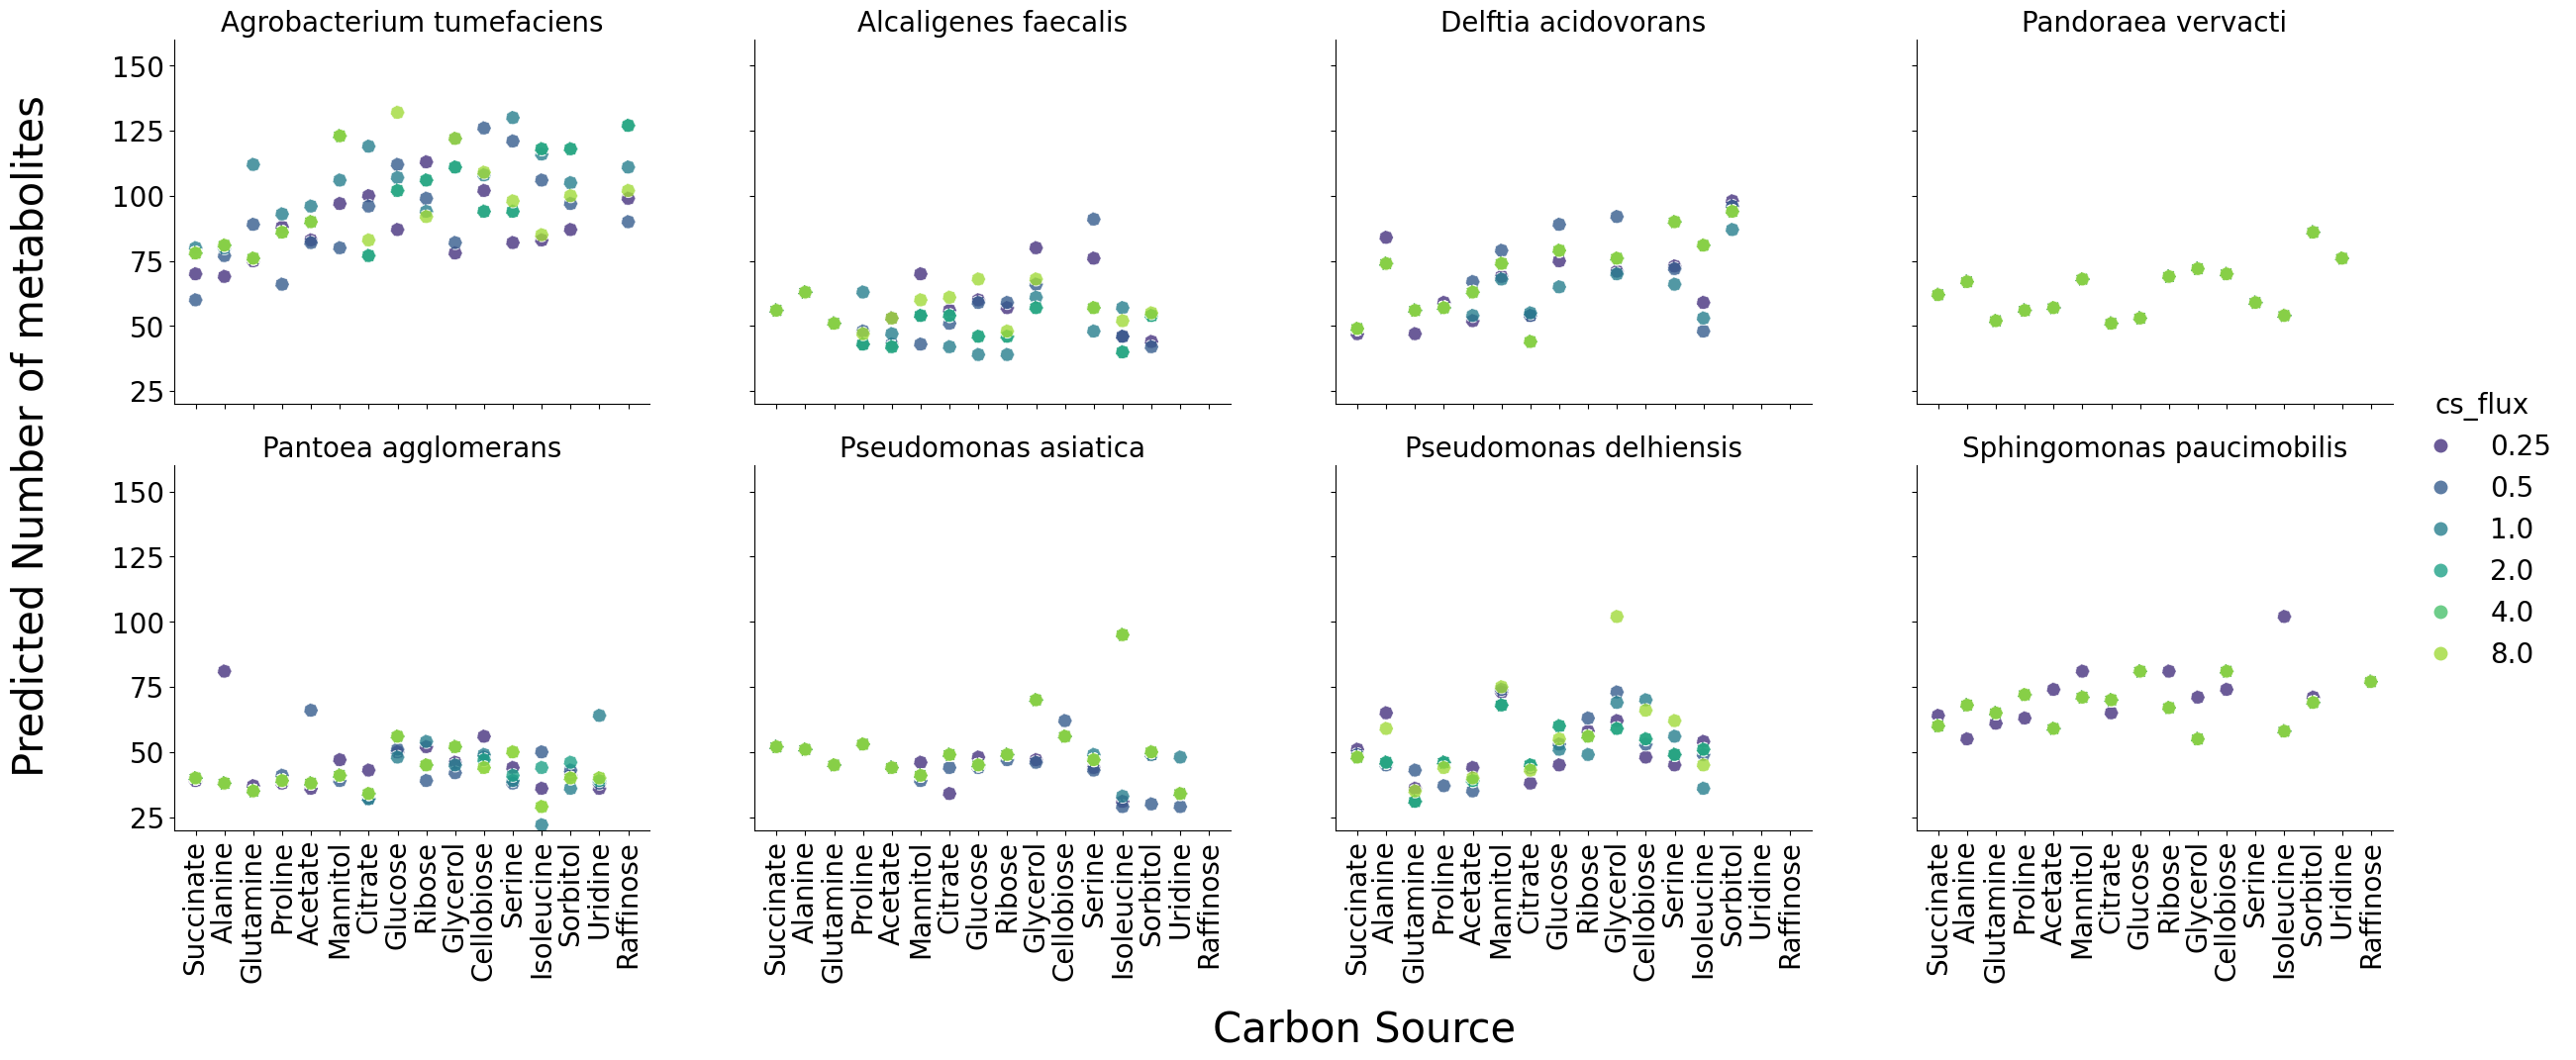

In [29]:
# Visualization Nonessential specific
my_df=copy.deepcopy(nesspmtb_count_table)

with sns.plotting_context(rc={'font.size':20,"axes.titlesize":20}):
    g=sns.relplot(data=my_df,x="carbon",y="number_nzfmtb_ca",hue=my_df["cs_flux"].astype('category'),
                  col="species",col_wrap=4,
                  height=5, aspect=1.3,
                  kind="scatter",palette="viridis",marker='o',linestyle='--',s=100,alpha=0.8)
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.tick_params(axis='x', rotation=90)
    g.set(ylim=(20,160))
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9,left=0.12) # adjust the Figure in rp
    g.fig.text(0.06,0.5, "Predicted Number of metabolites", va="center",rotation='vertical',fontsize=30)
    g.fig.text(0.5,-0.1, "Carbon Source", va="center",fontsize=30)
    plt.show()

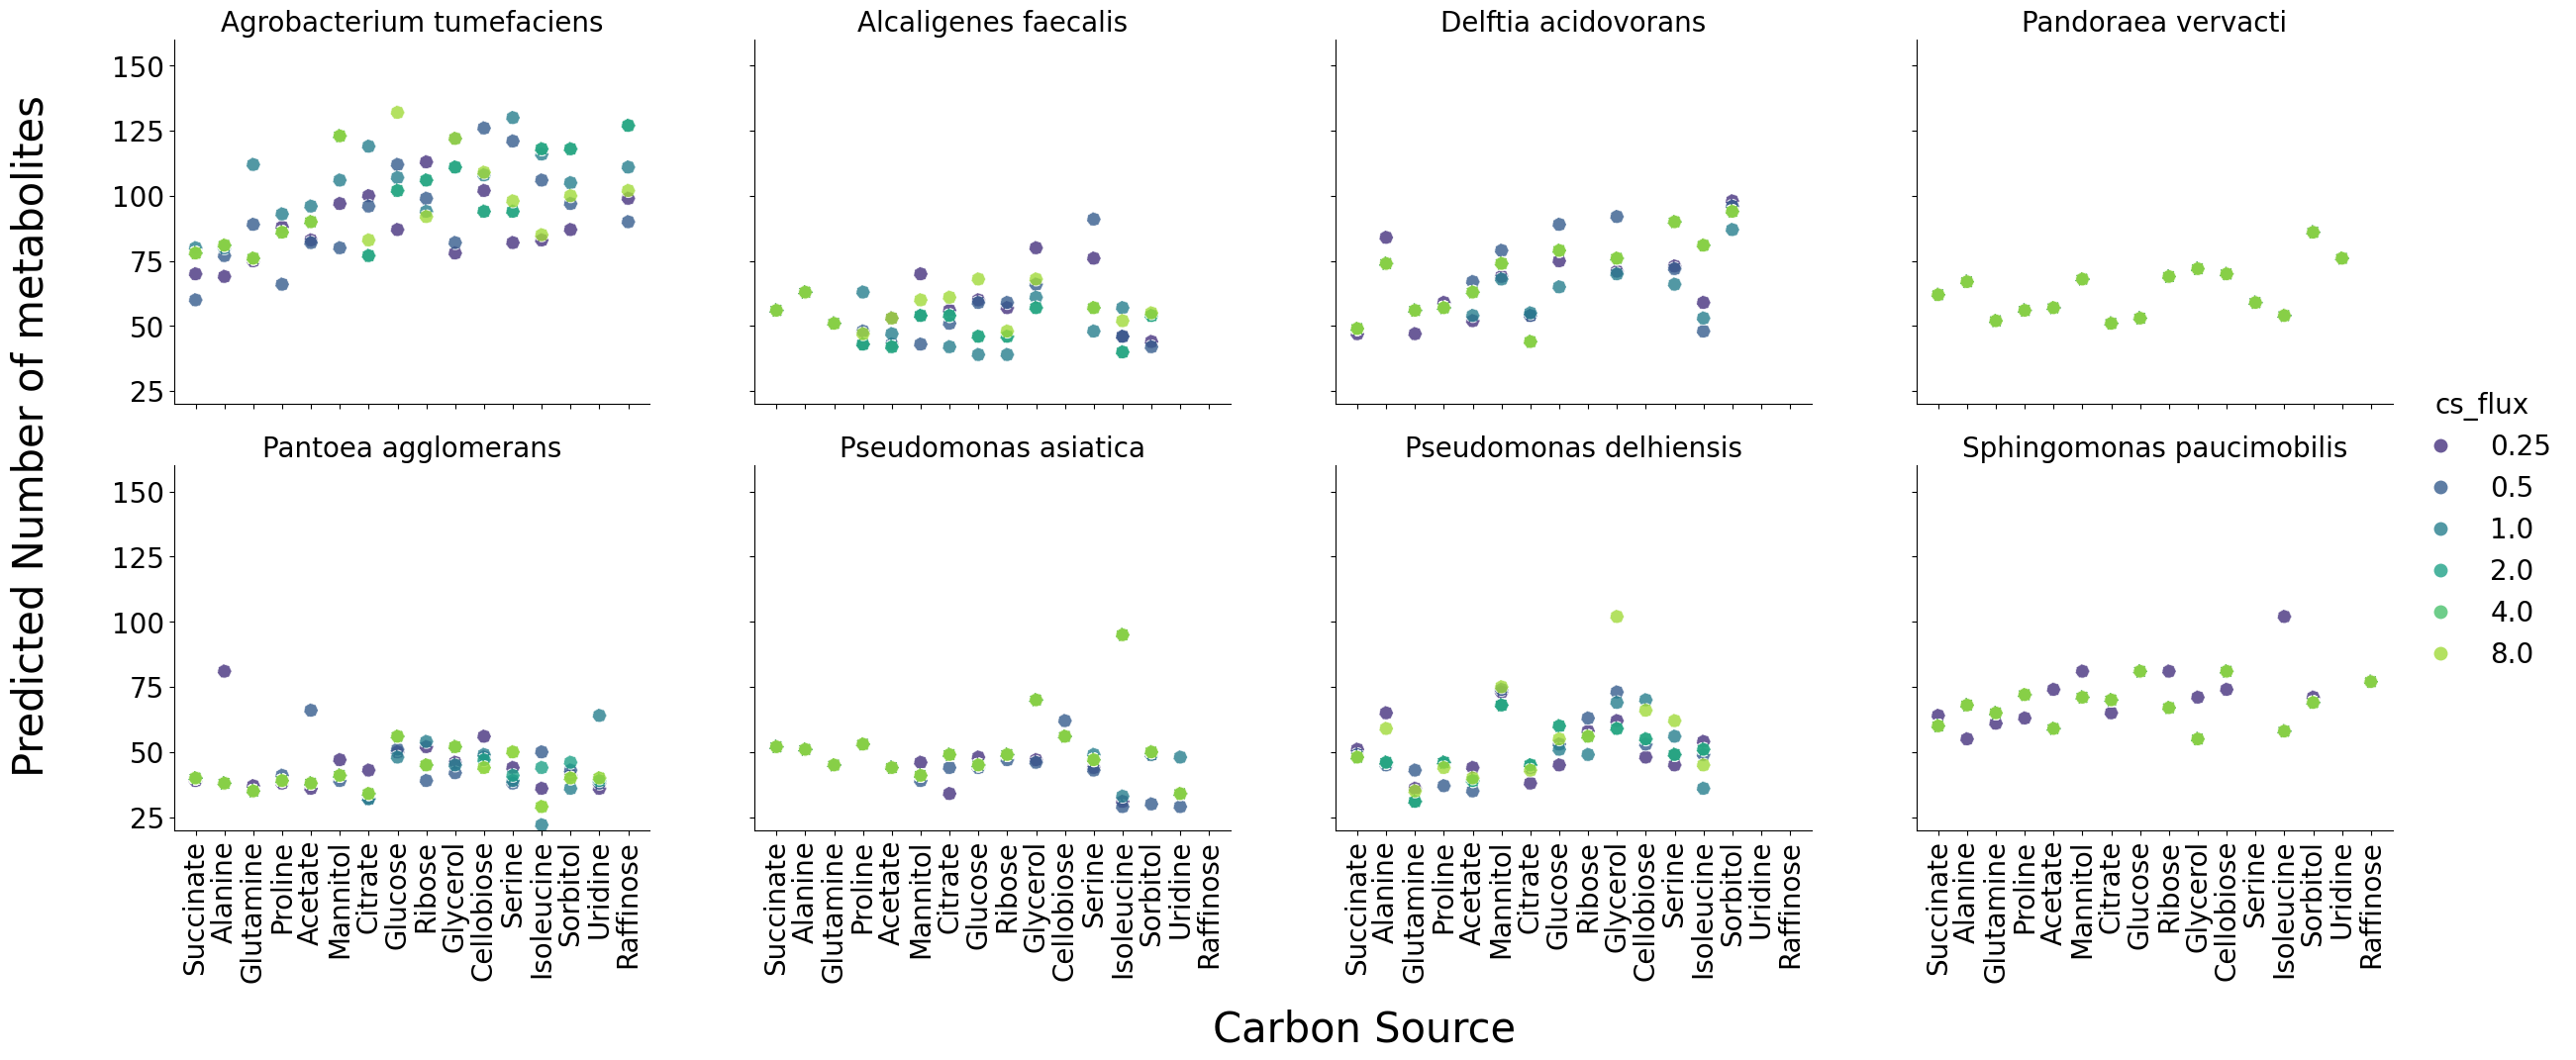

In [30]:
# Visualization Nonessential specific
my_df = copy.deepcopy(nesspmtb_count_table)

with sns.plotting_context(rc={'font.size': 20, "axes.titlesize": 20}):
    g = sns.relplot(
        data=my_df,
        x="carbon",
        y="number_nzfmtb_ca",
        hue=my_df["cs_flux"].astype('category'),
        col="species",
        col_wrap=4,
        height=5,
        aspect=1.3,
        kind="scatter",
        palette="viridis",
        marker='o',
        linestyle='--',
        s=100,
        alpha=0.8
    )
    g.set_ylabels("", clear_inner=False)
    g.set_xlabels("", clear_inner=False)
    g.tick_params(axis='x', rotation=90)
    g.set(ylim=(20, 160))
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9, left=0.12)  # adjust the Figure in rp
    g.fig.text(
        0.06, 0.5,
        "Predicted Number of metabolites",
        va="center",
        rotation='vertical',
        fontsize=30
    )
    g.fig.text(
        0.5, -0.1,
        "Carbon Source",
        va="center",
        fontsize=30
    )
    plt.show()

## Outputs

In [31]:
flux_melted.to_csv("FBA_cell_output/flux_melted.csv", index=False)
mtbrxn_all_df.to_csv("FBA_cell_output/mtbrxn_all_df.csv", index=False)
mtb_df.to_csv("FBA_cell_output/mtb_df.csv", index=False)
gr_melted.to_csv("FBA_cell_output/gr_melted.csv", index=False)
mtb_count_table.to_csv("FBA_cell_output/mtb_count_table.csv", index=False)
nzfmtb_df.to_csv("FBA_cell_output/nzfmtb_df.csv", index=False)
nzfmtb_ca_df.to_csv("FBA_cell_output/nzfmtb_ca_df.csv", index=False)
essmtb_count_table.to_csv("FBA_cell_output/essmtb_count_table.csv" ,index=False)
nesspmtb_count_table.to_csv("FBA_cell_output/nesspmtb_count_table.csv" ,index=False)
sp_model_df.to_csv("FBA_cell_output/sp_model_df.csv", index=False)

with open("FBA_cell_output/species.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(species)

with open("FBA_cell_output/species_abb.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(species_abb)

with open("FBA_cell_output/models.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(models)

with open("FBA_cell_output/carbons.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(carbons)

list1 = [[x] for x in glc_flux_list]
with open("FBA_cell_output/glc_flux_list.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list1)